# Step 0.Set-up

In [3]:
import pandas as pd
import numpy as np
import torch
import time
import random
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from transformers import EsmTokenizer, EsmModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
!pip install transformers torch biopython pandas scikit-learn
import seaborn as sns
from Bio import SeqIO
import xgboost as xgb

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Methods

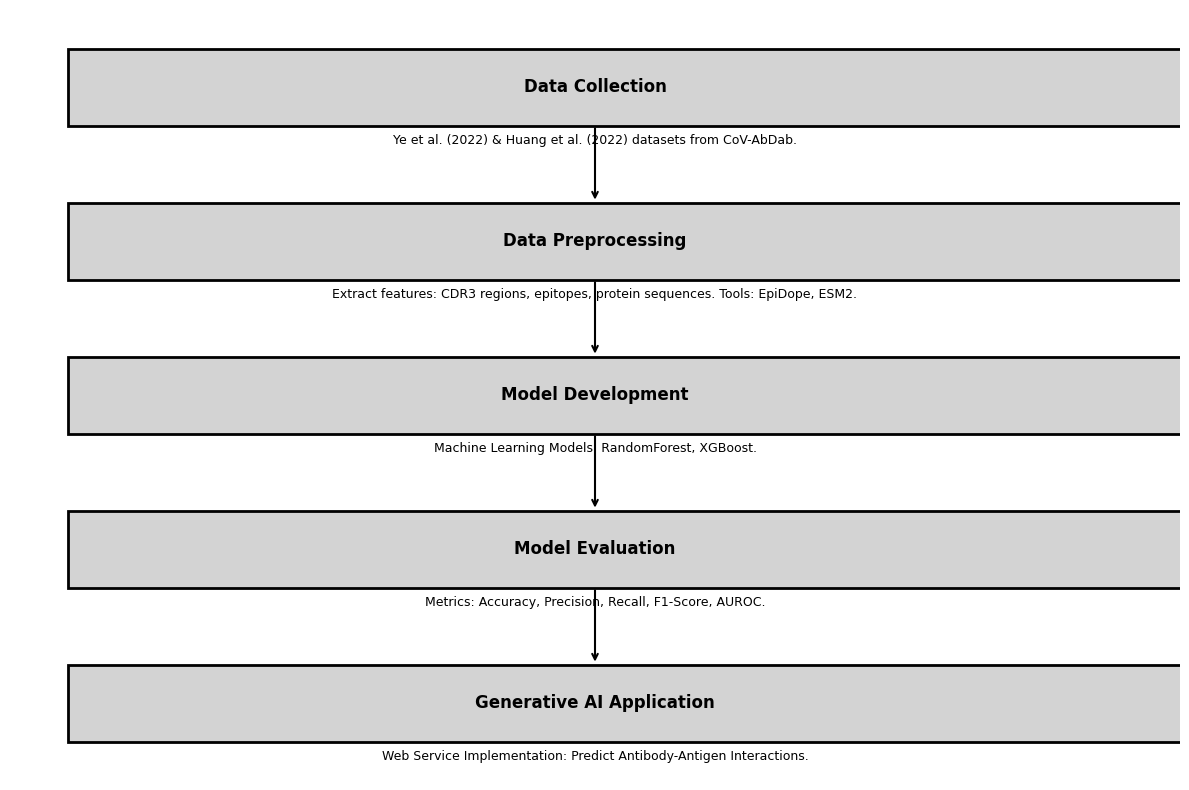

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define positions for each box
positions = {
    "Data Collection": (0.5, 5.5),
    "Data Preprocessing": (0.5, 4.5),
    "Model Development": (0.5, 3.5),
    "Model Evaluation": (0.5, 2.5),
    "Generative AI Application": (0.5, 1.5),
}

# Define connections
connections = [
    ("Data Collection", "Data Preprocessing"),
    ("Data Preprocessing", "Model Development"),
    ("Model Development", "Model Evaluation"),
    ("Model Evaluation", "Generative AI Application"),
]

# Define descriptions
descriptions = {
    "Data Collection": "Ye et al. (2022) & Huang et al. (2022) datasets from CoV-AbDab.",
    "Data Preprocessing": "Extract features: CDR3 regions, epitopes, protein sequences. Tools: EpiDope, ESM2.",
    "Model Development": "Machine Learning Models: RandomForest, XGBoost.",
    "Model Evaluation": "Metrics: Accuracy, Precision, Recall, F1-Score, AUROC.",
    "Generative AI Application": "Web Service Implementation: Predict Antibody-Antigen Interactions.",
}

# Draw boxes and text
for key, pos in positions.items():
    # Add rectangles for each stage
    rect = patches.Rectangle((pos[0] - 0.45, pos[1] - 0.25), 1, 0.5, linewidth=2, edgecolor='black', facecolor='lightgrey')
    ax.add_patch(rect)
    # Add text
    ax.text(pos[0], pos[1], key, fontsize=12, weight='bold', ha='center', va='center')
    ax.text(pos[0], pos[1] - 0.35, descriptions[key], fontsize=9, ha='center', va='center', wrap=True)

# Draw arrows
for start, end in connections:
    start_pos = positions[start]
    end_pos = positions[end]
    ax.annotate("", xy=(end_pos[0], end_pos[1] + 0.25), xytext=(start_pos[0], start_pos[1] - 0.25),
                arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

# Set limits and remove axes
ax.set_xlim(0, 1)
ax.set_ylim(1, 6)
ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

# Step 1. Processed dataset

## 1.1 Loading the dataset

In [ ]:
file_path = '/content/drive/MyDrive/Capstone_Collab/data_combine.csv'

# Try reading the CSV file with ISO-8859-1 encoding
clean_data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows of the dataframe
clean_data.head()

Seq_Hchain      H_CDR1      H_CDR2                 H_CDR3 Seq_Lchain  \
0    IGHV2-5  GFSLSTSGVG     IYWNDDK         AHRPIAIAAAAFDY   IGKV2-28   
1   IGHV3-15    GFTFSNAW  IKSKTDGGTT      TTATYVLRFLYYYYMDV   IGKV3-15   
2   IGHV3-30    GFTFSSYA    ISYDGSNK  AKDDNRENYDVLTGYYGPFDY    IGKV1-5   
3    IGHV3-7    GFTFSSYW    IKQDGSEK           ASYRYGDYVFDY    IGKV4-1   
4    IGHV1-2    GYTFTGYY    INPNSGGT        AVSGVAARLYYGMDV   IGKV1-17   

         L_CDR1 L_CDR2     L_CDR3  Hydro_L1  pl_L1  ...  pl_H1  Hydro_H2  \
0   QSLLHSNGYNY    LGS  MQALQTPGT      -0.7    7.7  ...    6.0       0.2   
1        QSVSSN    GAS   QQYNNWWT       0.0    6.0  ...    6.0       0.6   
2        QSISSW    DAS  QQYMSYPWT      -0.7    6.0  ...    5.9       0.3   
3  QSVLYSSNNKNY    WAS  QQCYSTPLT      -0.3    9.5  ...    5.9       1.3   
4        QGIRND    AAS  LQHNSHPRT       0.8    6.7  ...    5.8      -0.2   

   pl_H2  Hydro_H3  pl_H3                                            Epitope  \
0    3.9      -0.4    7.7  V,FPNI,ATRFAS,YAWNRKRISNCVA,ASFSTFK,V,IRGDEVRQ...   
1    9.8      -1.0    6.5  V,FPNI,ATRFAS,YAWNRKRISNCVA,ASFSTFK,V,IRGDEVRQ...   
2    6.6       0.3    3.8  V,FPNI,ATRFAS,YAWNRKRISNCVA,ASFSTFK,V,IRGDEVRQ...   
3    7.0      -0.4    3.9  V,FPNI,ATRFAS,YAWNRKRISNCVA,ASFSTFK,V,IRGDEVRQ...   
4    6.0      -0.5    6.6  V,FPNI,ATRFAS,YAWNRKRISNCVA,ASFSTFK,V,IRGDEVRQ...   

   RosettaChosenTotalSccore  RosettaScore    antigen  Docking  
0                      -1.0          -1.0  SARS-CoV2        Y  
1                      -1.0          -1.0  SARS-CoV2        Y  
2                      -1.0          -1.0  SARS-CoV2        Y  
3                      -1.0          -1.0  SARS-CoV2        Y  
4                      -1.0          -1.0  SARS-CoV2        Y  

[5 rows x 25 columns]

In [ ]:
# Display basic information about the dataset
print("Basic Information:")
print(clean_data.info())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5041 entries, 0 to 5040
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Seq_Hchain                5041 non-null   object 
 1   H_CDR1                    5041 non-null   object 
 2   H_CDR2                    5041 non-null   object 
 3   H_CDR3                    5041 non-null   object 
 4   Seq_Lchain                4956 non-null   object 
 5   L_CDR1                    5041 non-null   object 
 6   L_CDR2                    5041 non-null   object 
 7   L_CDR3                    5041 non-null   object 
 8   Hydro_L1                  5041 non-null   float64
 9   pl_L1                     5041 non-null   float64
 10  Hydro_L2                  5041 non-null   float64
 11  pl_L2                     5041 non-null   float64
 12  Hydro_L3                  5041 non-null   float64
 13  pl_L3                     5041 non-null   fl

In [ ]:
# Check for missing values in each column
missing_values = clean_data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Seq_Hchain                    0
H_CDR1                        0
H_CDR2                        0
H_CDR3                        0
Seq_Lchain                   85
L_CDR1                        0
L_CDR2                        0
L_CDR3                        0
Hydro_L1                      0
pl_L1                         0
Hydro_L2                      0
pl_L2                         0
Hydro_L3                      0
pl_L3                         0
Hydro_H1                      0
pl_H1                         0
Hydro_H2                      0
pl_H2                         0
Hydro_H3                      0
pl_H3                         0
Epitope                     995
RosettaChosenTotalSccore      0
RosettaScore                  0
antigen                       0
Docking                       0
dtype: int64


In [ ]:
# Check unique values for each column
unique_values = clean_data.nunique()
print("\nUnique Values:")
print(unique_values)


Unique Values:
Seq_Hchain                   169
H_CDR1                       127
H_CDR2                       135
H_CDR3                      1854
Seq_Lchain                   165
L_CDR1                       129
L_CDR2                        99
L_CDR3                      1459
Hydro_L1                      20
pl_L1                         32
Hydro_L2                      30
pl_L2                         22
Hydro_L3                      26
pl_L3                         51
Hydro_H1                      16
pl_H1                         23
Hydro_H2                      23
pl_H2                         38
Hydro_H3                      27
pl_H3                         79
Epitope                       48
RosettaChosenTotalSccore     600
RosettaScore                 576
antigen                       61
Docking                        2
dtype: int64


In [ ]:
# Get the sample size of the categories in the 'Docking' column
docking_counts = clean_data['Docking'].value_counts()

# Convert the counts to a DataFrame for better visualization
docking_counts_df = docking_counts.reset_index()
docking_counts_df.columns = ['Docking', 'Sample Size']

# Display the sample size of the categories
print(docking_counts_df)

  Docking  Sample Size
0       Y         3290
1       N         1751


## 1.2 Prepating a small balanced dataset

In [ ]:
# Extract a balanced subset of the data for the trial (50 sequences for each class)
subset_size = 100
clean_data_balanced = clean_data.groupby('Docking').apply(lambda x: x.sample(subset_size // 2, random_state=42)).reset_index(drop=True)

# Extract sequences from the balanced subset
heavy_sequences = clean_data_balanced['H_CDR3'].tolist()
light_sequences = clean_data_balanced['L_CDR3'].tolist()

# Define the separator token
separator_token = '|'

# Fill NaN values with an empty string to avoid split errors
clean_data_balanced['Epitope'] = clean_data_balanced['Epitope'].fillna('')

# Split the Epitope sequences
clean_data_balanced['antigen_list'] = clean_data_balanced['Epitope'].apply(lambda x: x.split(','))

# Save the Epitope sequences for ESM feature extraction using the separator token
clean_data_balanced['antigen_sequences'] = clean_data_balanced['antigen_list'].apply(lambda x: separator_token.join(x))

# Extract the antigen sequences from the balanced subset
antigen_sequences = clean_data_balanced['antigen_sequences'].tolist()

# Print the relevant columns to verify
print(clean_data_balanced[['Epitope', 'antigen_list', 'antigen_sequences']].head(10))

                                             Epitope  \
0                                                      
1  PNITN,V,TKFPS,YAWERKKISNCVA,YNSTFFSTFK,VVKGDDV...   
2  PNITN,V,TKFPS,YAWERKKISNCVA,YNSTFFSTFK,VVKGDDV...   
3  PNITN,V,TKFPS,YAWERKKISNCVA,YNSTFFSTFK,VVKGDDV...   
4  PNITN,V,TKFPS,YAWERKKISNCVA,YNSTFFSTFK,VVKGDDV...   
5  GSC,KVSF,KTFNGTGPCTNV,A,TD,A,QFGN,SSGGDPEI,FNG...   
6  VTENFNWCKNDMVEQMHEDIISLWDQSLKPCVKLTP,VITQACPKV...   
7                                                      
8                                                      
9  AYKQFIPNVAEKTLGASGRYEGKISRNSERFKELTPN,IFKDEENT...   

                                        antigen_list  \
0                                                 []   
1  [PNITN, V, TKFPS, YAWERKKISNCVA, YNSTFFSTFK, V...   
2  [PNITN, V, TKFPS, YAWERKKISNCVA, YNSTFFSTFK, V...   
3  [PNITN, V, TKFPS, YAWERKKISNCVA, YNSTFFSTFK, V...   
4  [PNITN, V, TKFPS, YAWERKKISNCVA, YNSTFFSTFK, V...   
5  [GSC, KVSF, KTFNGTGPCTNV, A, TD, A, QFGN, SS

## 1.3 Feature extraction vis ESM2

In [ ]:
# Load pre-trained ESM2 model and tokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a function to extract features using the ESM2 model and print intermediate steps
def extract_features(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    print("Tokenized Input:")
    print(inputs)

    with torch.no_grad():
        outputs = model(**inputs)

    print("\nEmbeddings:")
    print(outputs.last_hidden_state)

    # Return the mean of the embeddings as the feature vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Measure time for feature extraction
start_time = time.time()

# Extract features for heavy, light, and antigen sequences (trial run)
heavy_features = [extract_features(seq) for seq in heavy_sequences]
light_features = [extract_features(seq) for seq in light_sequences]
antigen_features = [extract_features(seq) for seq in antigen_sequences]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction (trial run): {elapsed_time} seconds")

# Convert lists to numpy arrays
heavy_features = np.array(heavy_features)
light_features = np.array(light_features)
antigen_features = np.array(antigen_features)

Streaming output truncated to the last 5000 lines.
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}

Embeddings:
tensor([[[ 0.1206,  0.6720,  0.1732,  ...,  0.9068, -0.1696, -0.3203],
         [ 0.0336,  0.2488,  0.2737,  ...,  0.0980, -0.1748, -0.0236],
         [ 0.1408, -0.0795,  0.2492,  ...,  0.0708, -0.0626, -0.0852],
         ...,
         [ 0.0550, -0.1008,  0.3690,  ...,  0.0867, -0.1602, -0.1347],
         [ 0.3386,  0.0185,  0.1796,  ..., -0.2787, -0.1260, -0.0160],
         [ 0.0800,  0.0270,  0.2893,  ...,  0.3768, -0.5936, -0.0587]]])
Tokenized Input:
{'input_ids': tensor([[0, 2]]), 'attention_mask': tensor([[1, 1]])}

Embeddings:
tensor([[[ 2.3975e-01,  1.4475e-01,  3.6727e-01,  4.6139e-01,  1.3786e-02,
           1.2481e-01, -4.2486e-01, -4.3736e-03, -1.4008e

In [ ]:
# Print shapes of the extracted features
print(f"Heavy features shape: {heavy_features.shape}")
print(f"Light features shape: {light_features.shape}")
print(f"Antigen features shape: {antigen_features.shape}")

Heavy features shape: (100, 320)
Light features shape: (100, 320)
Antigen features shape: (100, 320)


In [ ]:
# Define the silent version of the extract_features function
def extract_features_silent(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)

    with torch.no_grad():
        outputs = model(**inputs)

    # Return the mean of the embeddings as the feature vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

Elapsed time for feature extraction (trial run): 11.754473209381104 seconds
Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.74      0.67      0.70        30
           1       0.57      0.65      0.60        20

    accuracy                           0.66        50
   macro avg       0.65      0.66      0.65        50
weighted avg       0.67      0.66      0.66        50

Confusion Matrix:
[[20 10]
 [ 7 13]]


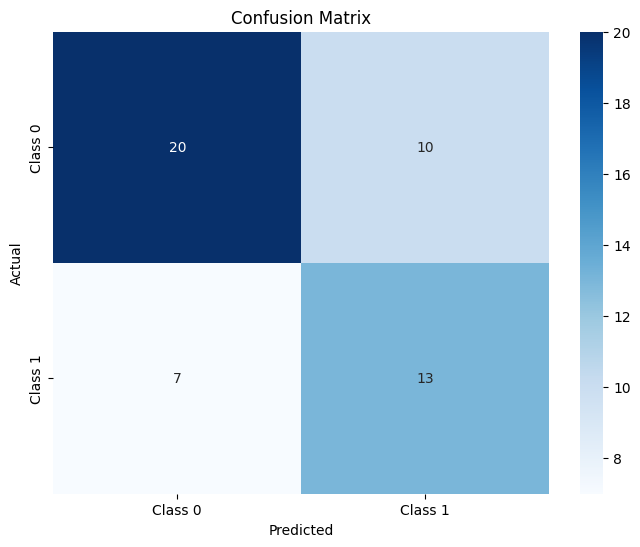

AUROC: 0.7341666666666666


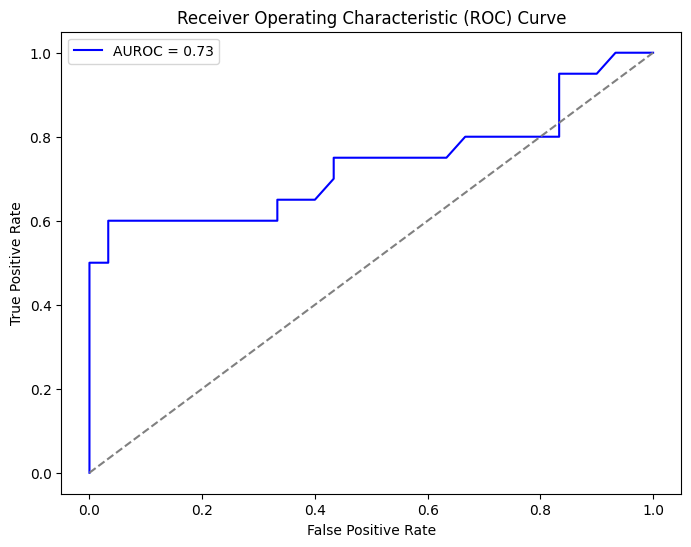

In [ ]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Defined the silent function for feature extraction
# 'model' and 'tokenizer' are already defined and loaded
# 'clean_data_balanced' DataFrame is ready

# Measure time for feature extraction
start_time = time.time()

# Extract features for heavy, light, and antigen sequences (trial run)
heavy_features = np.array([extract_features_silent(seq) for seq in heavy_sequences])
light_features = np.array([extract_features_silent(seq) for seq in light_sequences])
antigen_features = np.array([extract_features_silent(seq) for seq in antigen_sequences])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction (trial run): {elapsed_time} seconds")

# Combine features
combined_features = np.hstack([heavy_features, light_features, antigen_features])

# Extract the target variable
y = clean_data_balanced['Docking'].apply(lambda x: 1 if x == 'Y' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.5, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## 1.4 Final run

In [ ]:
# Separate negative and positive sequences
negative_sequences = clean_data[clean_data['Docking'] == 'N']
positive_sequences = clean_data[clean_data['Docking'] == 'Y']

# Balance positive sequences to match the number of negative sequences
balanced_positive_sequences = positive_sequences.sample(n=len(negative_sequences), random_state=42)
balanced_dataset = pd.concat([negative_sequences, balanced_positive_sequences])

In [ ]:
# Fill NaN values in the Epitope column with an empty string
clean_data['Epitope'] = clean_data['Epitope'].fillna('')

# Separate negative and positive sequences
negative_sequences = clean_data[clean_data['Docking'] == 'N']
positive_sequences = clean_data[clean_data['Docking'] == 'Y']

# Balance positive sequences to match the number of negative sequences
balanced_positive_sequences = positive_sequences.sample(n=len(negative_sequences), random_state=42)
balanced_dataset = pd.concat([negative_sequences, balanced_positive_sequences])

# Extract sequences from the balanced dataset
heavy_sequences = balanced_dataset['H_CDR3'].tolist()
light_sequences = balanced_dataset['L_CDR3'].tolist()
antigen_sequences = balanced_dataset['Epitope'].apply(lambda x: '|'.join(x.split(',')) if isinstance(x, str) else '').tolist()

In [ ]:
# Extract features for the entire dataset
start_time = time.time()

heavy_features = np.array([extract_features_silent(seq) for seq in heavy_sequences])
light_features = np.array([extract_features_silent(seq) for seq in light_sequences])
antigen_features = np.array([extract_features_silent(seq) for seq in antigen_sequences])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

Elapsed time for feature extraction: 419.78531789779663 seconds


### RandomForestClassifier

Accuracy: 0.8473609129814551
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       379
           1       0.86      0.80      0.83       322

    accuracy                           0.85       701
   macro avg       0.85      0.84      0.85       701
weighted avg       0.85      0.85      0.85       701

Confusion Matrix:
[[338  41]
 [ 66 256]]


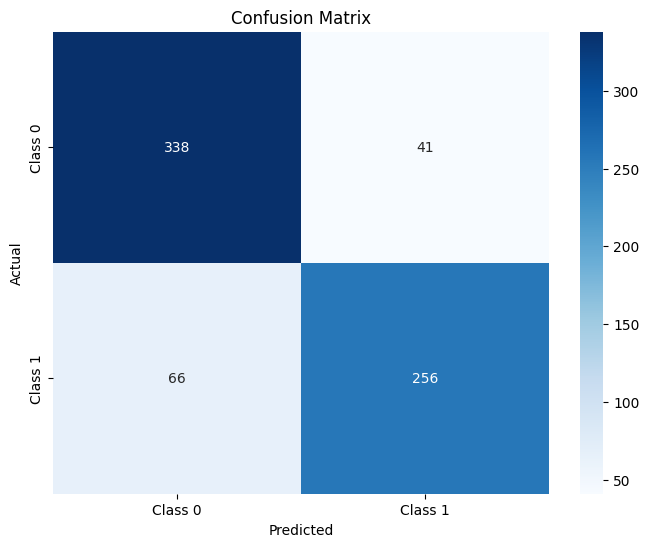

AUROC: 0.9176035333256856


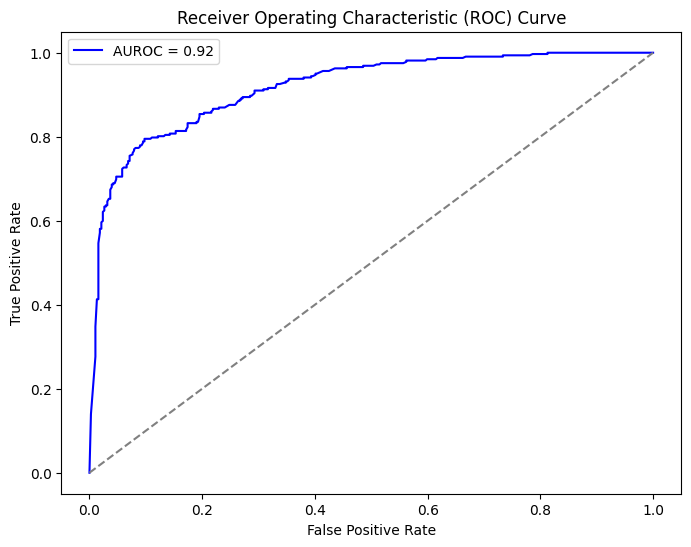

Full Dataset Accuracy: 0.8938702638365403
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1751
           1       0.98      0.86      0.91      3290

    accuracy                           0.89      5041
   macro avg       0.88      0.91      0.89      5041
weighted avg       0.91      0.89      0.90      5041

Full Dataset Confusion Matrix:
[[1690   61]
 [ 474 2816]]


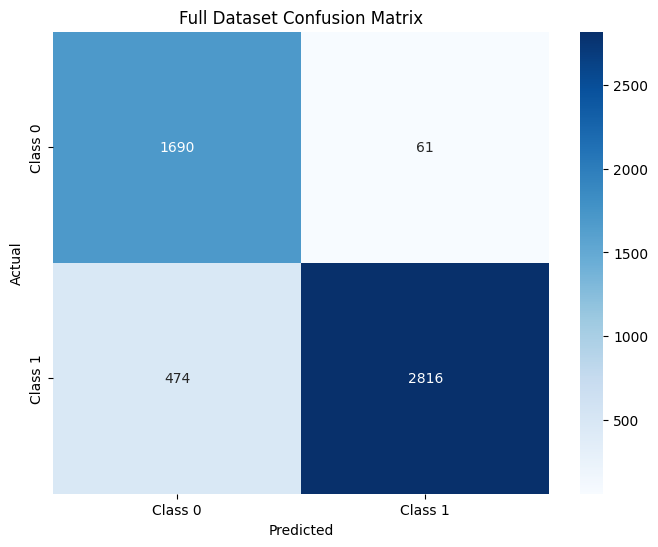

Full Dataset AUROC: 0.9707377807557644


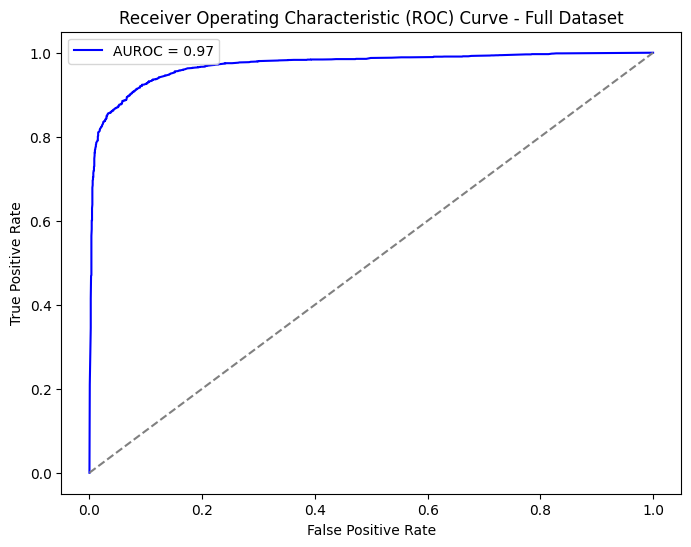

In [ ]:
# Combine features
combined_features = np.hstack([heavy_features, light_features, antigen_features])

# Extract the target variable
y = balanced_dataset['Docking'].apply(lambda x: 1 if x == 'Y' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Predict on the whole dataset
clean_data['Epitope'] = clean_data['Epitope'].fillna('')  # Ensure no NaN values

combined_features_full = np.hstack([
    np.array([extract_features_silent(seq) for seq in clean_data['H_CDR3'].tolist()]),
    np.array([extract_features_silent(seq) for seq in clean_data['L_CDR3'].tolist()]),
    np.array([extract_features_silent(seq) for seq in clean_data['Epitope'].apply(lambda x: '|'.join(x.split(',')) if isinstance(x, str) else '').tolist()])
])

y_full = clean_data['Docking'].apply(lambda x: 1 if x == 'Y' else 0).values
y_pred_full = rf_model.predict(combined_features_full)
y_pred_prob_full = rf_model.predict_proba(combined_features_full)[:, 1]

# Evaluate on the full dataset
accuracy_full = accuracy_score(y_full, y_pred_full)
print(f"Full Dataset Accuracy: {accuracy_full}")
print(classification_report(y_full, y_pred_full))

# Generate the confusion matrix for the full dataset
conf_matrix_full = confusion_matrix(y_full, y_pred_full)
print(f"Full Dataset Confusion Matrix:\n{conf_matrix_full}")

# Plot the confusion matrix for the full dataset
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Full Dataset Confusion Matrix')
plt.show()

# Calculate and print AUROC for the full dataset
auroc_full = roc_auc_score(y_full, y_pred_prob_full)
print(f"Full Dataset AUROC: {auroc_full}")

# Plot the AUROC curve for the full dataset
fpr_full, tpr_full, _ = roc_curve(y_full, y_pred_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'AUROC = {auroc_full:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Full Dataset')
plt.legend()
plt.show()

### XGBClassifier

Accuracy: 0.8359486447931527
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       379
           1       0.82      0.82      0.82       322

    accuracy                           0.84       701
   macro avg       0.84      0.83      0.83       701
weighted avg       0.84      0.84      0.84       701

Confusion Matrix:
[[323  56]
 [ 59 263]]


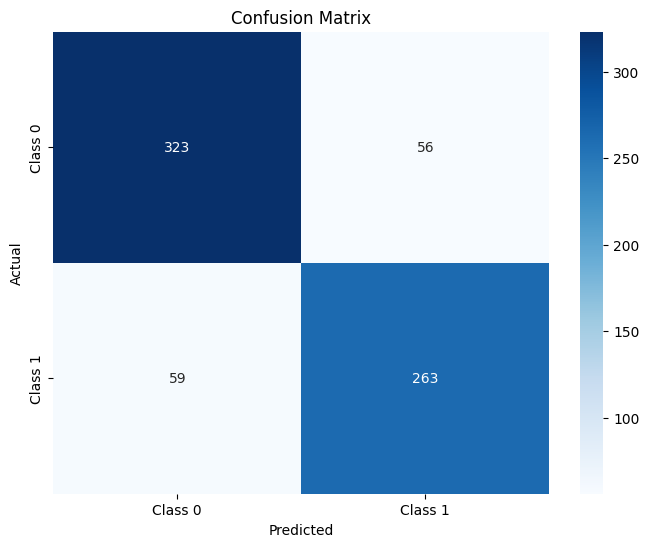

AUROC: 0.9151043117717432


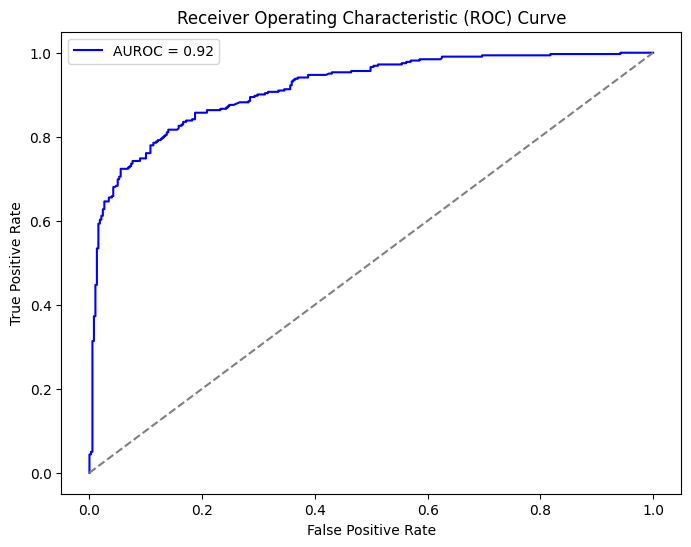

Full Dataset Accuracy: 0.8960523705613965
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      1751
           1       0.97      0.86      0.92      3290

    accuracy                           0.90      5041
   macro avg       0.88      0.91      0.89      5041
weighted avg       0.91      0.90      0.90      5041

Full Dataset Confusion Matrix:
[[1676   75]
 [ 449 2841]]


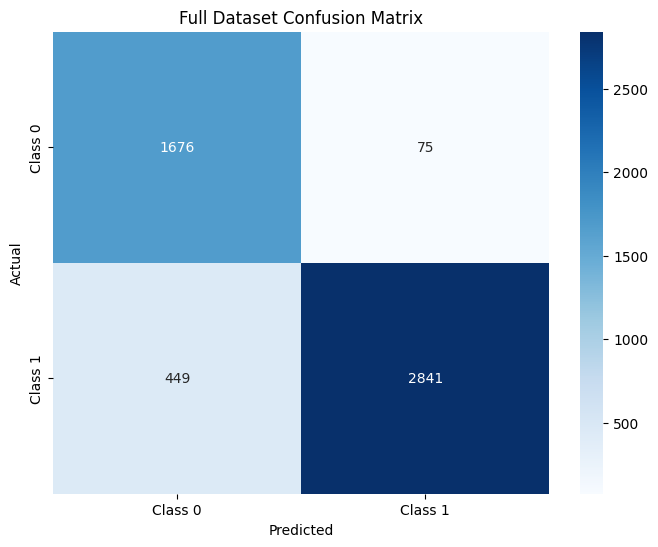

Full Dataset AUROC: 0.9673017936776034


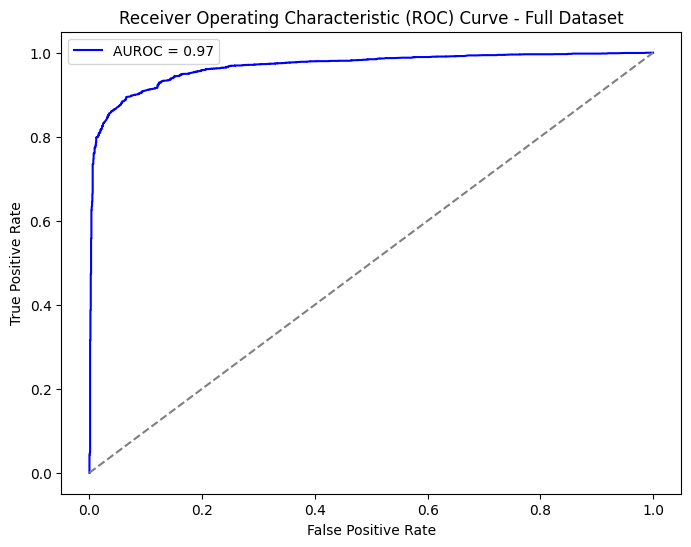

In [ ]:
# Combine features
combined_features = np.hstack([heavy_features, light_features, antigen_features])

# Extract the target variable
y = balanced_dataset['Docking'].apply(lambda x: 1 if x == 'Y' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Predict on the whole dataset
clean_data['Epitope'] = clean_data['Epitope'].fillna('')  # Ensure no NaN values

combined_features_full = np.hstack([
    np.array([extract_features_silent(seq) for seq in clean_data['H_CDR3'].tolist()]),
    np.array([extract_features_silent(seq) for seq in clean_data['L_CDR3'].tolist()]),
    np.array([extract_features_silent(seq) for seq in clean_data['Epitope'].apply(lambda x: '|'.join(x.split(',')) if isinstance(x, str) else '').tolist()])
])

y_full = clean_data['Docking'].apply(lambda x: 1 if x == 'Y' else 0).values
y_pred_full = xgb_model.predict(combined_features_full)
y_pred_prob_full = xgb_model.predict_proba(combined_features_full)[:, 1]

# Evaluate on the full dataset
accuracy_full = accuracy_score(y_full, y_pred_full)
print(f"Full Dataset Accuracy: {accuracy_full}")
print(classification_report(y_full, y_pred_full))

# Generate the confusion matrix for the full dataset
conf_matrix_full = confusion_matrix(y_full, y_pred_full)
print(f"Full Dataset Confusion Matrix:\n{conf_matrix_full}")

# Plot the confusion matrix for the full dataset
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Full Dataset Confusion Matrix')
plt.show()

# Calculate and print AUROC for the full dataset
auroc_full = roc_auc_score(y_full, y_pred_prob_full)
print(f"Full Dataset AUROC: {auroc_full}")

# Plot the AUROC curve for the full dataset
fpr_full, tpr_full, _ = roc_curve(y_full, y_pred_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'AUROC = {auroc_full:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Full Dataset')
plt.legend()
plt.show()

# Step 2. Raw dataset

## 2.1 Loading the dataset

In [5]:
# Define file paths
positive_file_path = '/content/drive/MyDrive/Capstone_Collab/Dataset2/positive dataset.txt'
negative_file_path = '/content/drive/MyDrive/Capstone_Collab/Dataset2/negative dataset.txt'

# Specify the headers for the columns
headers = ['Virus', 'Antibody', 'Antigen']

# Read the text files with ISO-8859-1 encoding, specifying the headers
positive_data = pd.read_csv(positive_file_path, encoding='ISO-8859-1', delimiter='\t', names=headers)
negative_data = pd.read_csv(negative_file_path, encoding='ISO-8859-1', delimiter='\t', names=headers)

# Display the first few rows of the dataframes
print("Positive Dataset:")
print(positive_data.head())

print("\nNegative Dataset:")
print(negative_data.head())

Positive Dataset:
       Virus                                           Antibody  \
0  SARS-CoV1  QVQLQQPGAELVLPGASVKLSCKASGYTFTNYWMHWVKQRPGHGLE...   
1  SARS-CoV1  QVQLQQPGAELVKPGASVKMSCKASGYNFNHYWISWVKQRPGQGLE...   
2  SARS-CoV1  EVQLKQSVAELVRPGASVKVSCTASGFNIKNIYMHWVKQRPEQGLD...   
3  SARS-CoV1  QVQLQQPGAELVKPGASVKMSCKASGYTFITYWITWVKQRPGQGLE...   
4  SARS-CoV1  QVQLVQSGAEVKKPGASVKVSCKASGYPFTSYGISWVRQAPGQGLE...   

                                             Antigen  
0  DIVMTQSHKFMSTSVGDRVSITCKASQDVGTYIAWYQQKPGQSPKL...  
1  DILLTQFPAILSVSPGERVSFSCRASQTIGTNIHWYQQRINGSPRL...  
2  DIVMTQSPSSLTVTAGEKVTMSCKSSQSLLNSGNQKNYLTWYQQKV...  
3  DIVLTQSPVSLAVSLGQRATISCRASESVDFYGNSFIYWYQQKPGQ...  
4  EIVLTQSPGTLSLSPGERATLSCRASQTVSSTSLAWYQQKPGQAPR...  

Negative Dataset:
       Virus                                           Antibody  \
0  SARS-CoV1  QVQLQQPGTELVMPGASVKLSCKTSGYTFTHYWMHWVKQRPGEGLE...   
1  SARS-CoV1  QAYLQQSGAEMVRPGASVKMSCKASGYTFNNYNMHWVKQTPSQGLE...   
2  SARS-CoV1  EVQLQQSGPELVKPG

In [6]:
# Display the shape of the dataframes
print("Shape of Positive Dataset:", positive_data.shape)
print("Shape of Negative Dataset:", negative_data.shape)

# Count of missing values in each column
print("\nMissing values in Positive Dataset:")
print(positive_data.isnull().sum())

print("\nMissing values in Negative Dataset:")
print(negative_data.isnull().sum())

# Count of unique values in each column
print("\nUnique values in Positive Dataset:")
print(positive_data.nunique())

print("\nUnique values in Negative Dataset:")
print(negative_data.nunique())

Shape of Positive Dataset: (9309, 3)
Shape of Negative Dataset: (1710, 3)

Missing values in Positive Dataset:
Virus       0
Antibody    0
Antigen     0
dtype: int64

Missing values in Negative Dataset:
Virus       0
Antibody    0
Antigen     0
dtype: int64

Unique values in Positive Dataset:
Virus          2
Antibody    7347
Antigen     7141
dtype: int64

Unique values in Negative Dataset:
Virus          2
Antibody    1642
Antigen     1615
dtype: int64


## 2.2 ESM2 on sequences only

In [7]:
# Load pre-trained ESM2 model and tokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Define a function to extract features using the ESM2 model and print intermediate steps
def extract_features(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    print("Tokenized Input:")
    print(inputs)

    with torch.no_grad():
        outputs = model(**inputs)

    print("\nEmbeddings:")
    print(outputs.last_hidden_state)

    # Return the mean of the embeddings as the feature vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [9]:
# Extract features from the Antigen and Antibody columns
positive_data['Antigen_features'] = positive_data['Antigen'].apply(extract_features)
positive_data['Antibody_features'] = positive_data['Antibody'].apply(extract_features)
negative_data['Antigen_features'] = negative_data['Antigen'].apply(extract_features)
negative_data['Antibody_features'] = negative_data['Antibody'].apply(extract_features)

# Combine the features and create the labels
positive_features = np.hstack((positive_data['Antigen_features'].tolist(), positive_data['Antibody_features'].tolist()))
negative_features = np.hstack((negative_data['Antigen_features'].tolist(), negative_data['Antibody_features'].tolist()))

X = np.vstack((positive_features, negative_features))
y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))

Streaming output truncated to the last 5000 lines.
          7,  6, 22, 12, 10, 16, 14, 14,  6, 15,  5,  4,  9, 22,  4,  5,  4, 12,
         17, 22, 13, 13, 13, 15, 10, 19,  8, 14,  8,  4, 17,  8, 10,  4, 11, 12,
         11, 20, 13, 11,  8, 15, 17, 16,  7,  7,  4, 11, 20, 11, 17, 20, 13, 14,
          7, 13, 11,  5, 11, 19, 19, 23, 11, 21,  8, 10,  8,  6, 22,  8,  6,  6,
          5, 18, 13, 12, 22,  6, 16,  6,  5, 20,  7, 11,  7,  8,  8,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

Embeddings:
tensor([[[-0.0927,  0.8396,  0.1020,  ...,  0.8451, -0.1387, -0.4430],
         [ 0.1843,

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:19:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7722323049001815
              precision    recall  f1-score   support

         0.0       0.03      0.01      0.02       348
         1.0       0.83      0.91      0.87      1856

    accuracy                           0.77      2204
   macro avg       0.43      0.46      0.45      2204
weighted avg       0.71      0.77      0.74      2204

Confusion Matrix:
[[   5  343]
 [ 159 1697]]


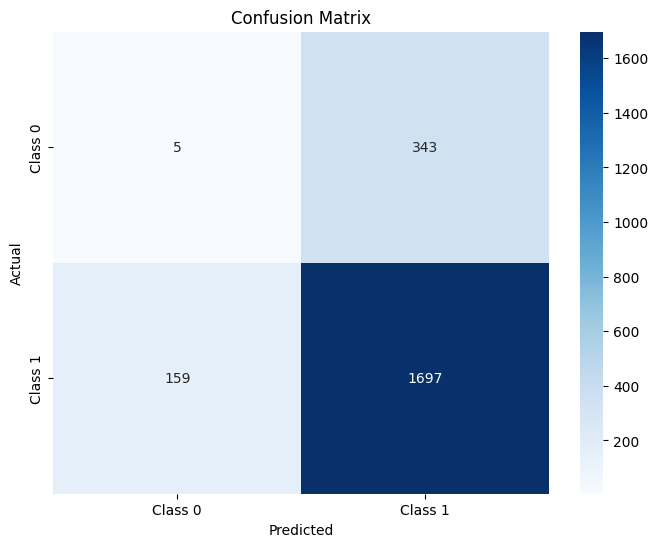

AUROC: 0.5448878133670234


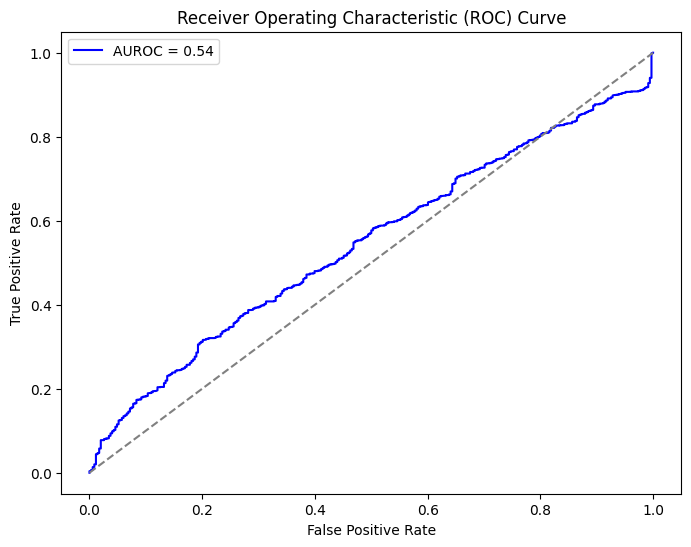

In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Final run

In [13]:
# Combine the positive and negative datasets
positive_data['Label'] = 1
negative_data['Label'] = 0
full_data = pd.concat([positive_data, negative_data], ignore_index=True)

# Extract features from the Antigen and Antibody columns
full_data['Antigen_features'] = full_data['Antigen'].apply(extract_features)
full_data['Antibody_features'] = full_data['Antibody'].apply(extract_features)

Streaming output truncated to the last 5000 lines.
          7,  6, 22, 12, 10, 16, 14, 14,  6, 15,  5,  4,  9, 22,  4,  5,  4, 12,
         17, 22, 13, 13, 13, 15, 10, 19,  8, 14,  8,  4, 17,  8, 10,  4, 11, 12,
         11, 20, 13, 11,  8, 15, 17, 16,  7,  7,  4, 11, 20, 11, 17, 20, 13, 14,
          7, 13, 11,  5, 11, 19, 19, 23, 11, 21,  8, 10,  8,  6, 22,  8,  6,  6,
          5, 18, 13, 12, 22,  6, 16,  6,  5, 20,  7, 11,  7,  8,  8,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

Embeddings:
tensor([[[-0.0927,  0.8396,  0.1020,  ...,  0.8451, -0.1387, -0.4430],
         [ 0.1843,

### XGBClassifier

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:50:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7722323049001815
              precision    recall  f1-score   support

           0       0.03      0.01      0.02       348
           1       0.83      0.91      0.87      1856

    accuracy                           0.77      2204
   macro avg       0.43      0.46      0.45      2204
weighted avg       0.71      0.77      0.74      2204

Confusion Matrix:
[[   5  343]
 [ 159 1697]]


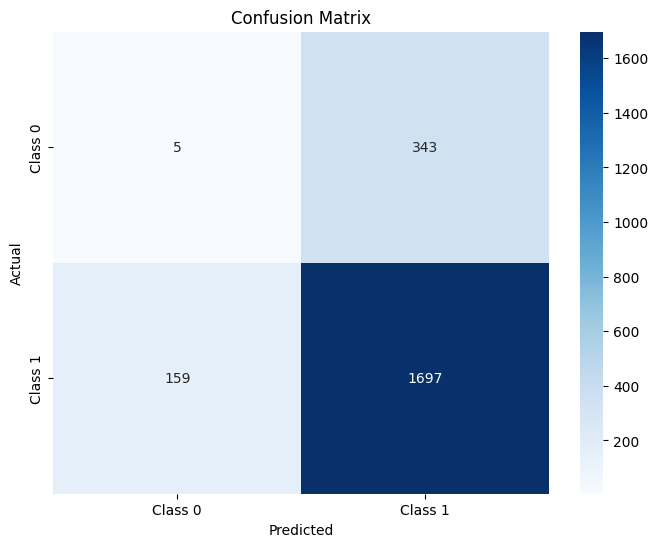

AUROC: 0.5448878133670234


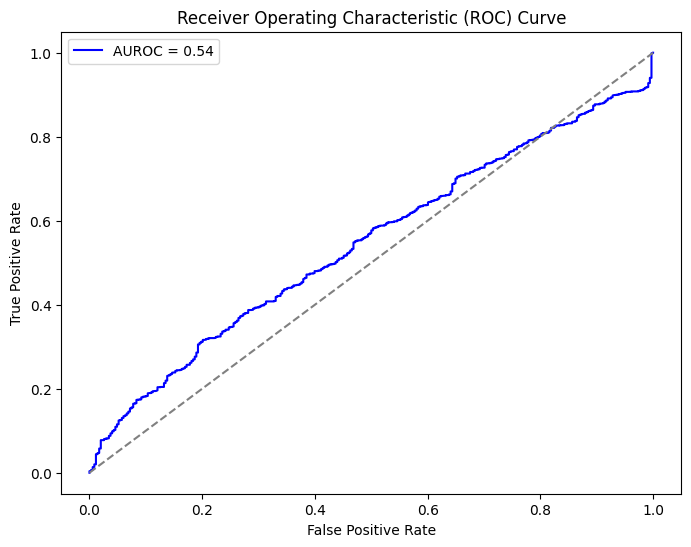

In [15]:
# Combine the features
full_features = np.hstack((full_data['Antigen_features'].tolist(), full_data['Antibody_features'].tolist()))

X = np.array(full_features)
y = full_data['Label'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Streaming output truncated to the last 5000 lines.
         [ 0.1843,  0.1917, -0.1386,  ...,  0.1012,  0.2191, -0.2873],
         [-0.7126, -0.2776,  0.2756,  ..., -0.0390, -0.1360,  0.4518],
         ...,
         [-0.3910, -0.7917, -0.2631,  ...,  0.4088,  0.3654, -0.0100],
         [-0.1348, -0.9476, -0.4433,  ...,  0.0957,  0.1281, -0.1543],
         [ 0.1643, -0.3939,  0.0295,  ...,  0.2417, -0.8127, -0.2083]]])
Tokenized Input:
{'input_ids': tensor([[ 0, 16, 12, 11,  4, 15,  9,  8,  6, 14, 11,  4,  7, 15, 14, 11, 16, 11,
          4, 11,  4, 11, 23, 11, 18,  8,  6, 18,  8,  4,  8, 11,  8,  6,  7,  6,
          7,  6, 22, 12, 10, 16, 14, 14,  6, 15,  5,  4,  9, 22,  4,  5,  4, 12,
         19, 22, 17, 13, 13, 15, 10, 19,  8, 14,  8,  4, 17,  8, 10,  4, 11, 12,
         11, 15, 13, 11,  8, 15, 17, 16,  7,  7,  4, 11, 20, 11, 17, 20, 13, 14,
          7, 13, 11,  5, 11, 19, 19, 23,  5, 21, 15, 14,  6,  6, 10, 19,  8,  4,
          5, 19, 18, 13, 19, 22,  6, 16,  6, 11,  4,  7, 11, 

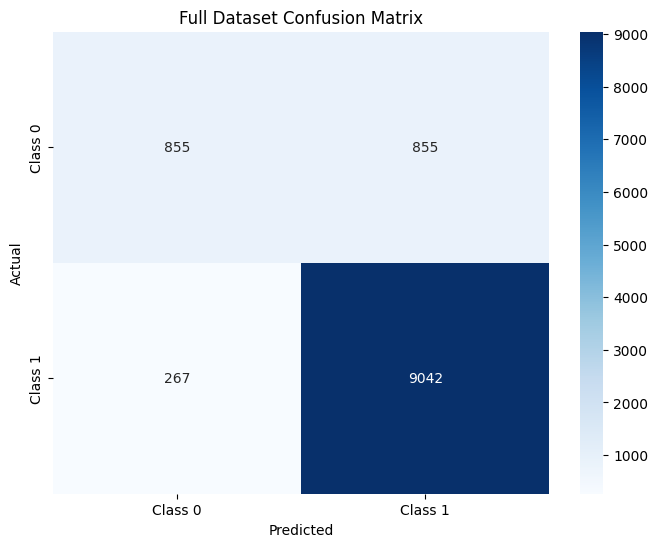

Full Dataset AUROC: 0.9092811207666103


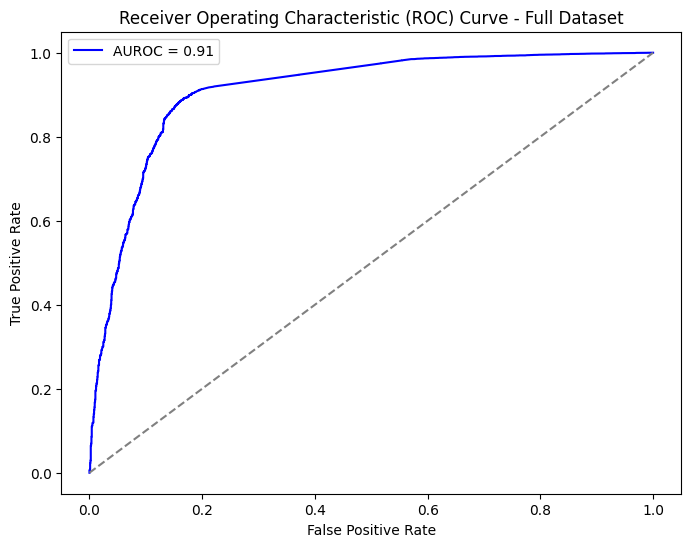

In [16]:
# Now let's predict on the whole dataset (using full_data)
full_data['Epitope'] = full_data['Antigen'].fillna('')  # Ensure no NaN values

# Define a silent feature extraction function for use with full_data
def extract_features_silent(sequence):
    try:
        return extract_features(sequence)
    except Exception as e:
        print(f"Error extracting features from sequence: {sequence}")
        return np.zeros((model.config.hidden_size,))

combined_features_full = np.hstack([
    np.array([extract_features_silent(seq) for seq in full_data['Antigen'].tolist()]),
    np.array([extract_features_silent(seq) for seq in full_data['Antibody'].tolist()])
])

y_full = full_data['Label'].values
y_pred_full = xgb_model.predict(combined_features_full)
y_pred_prob_full = xgb_model.predict_proba(combined_features_full)[:, 1]

# Evaluate on the full dataset
accuracy_full = accuracy_score(y_full, y_pred_full)
print(f"Full Dataset Accuracy: {accuracy_full}")
print(classification_report(y_full, y_pred_full))

# Generate the confusion matrix for the full dataset
conf_matrix_full = confusion_matrix(y_full, y_pred_full)
print(f"Full Dataset Confusion Matrix:\n{conf_matrix_full}")

# Plot the confusion matrix for the full dataset
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Full Dataset Confusion Matrix')
plt.show()

# Calculate and print AUROC for the full dataset
auroc_full = roc_auc_score(y_full, y_pred_prob_full)
print(f"Full Dataset AUROC: {auroc_full}")

# Plot the AUROC curve for the full dataset
fpr_full, tpr_full, _ = roc_curve(y_full, y_pred_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'AUROC = {auroc_full:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Full Dataset')
plt.legend()
plt.show()

# Step 3. EpiDope - epitope prediction tool

In [ ]:
# Install Miniconda
!wget -qO- https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh
!bash miniconda.sh -b -p /usr/local/miniconda

# Update PATH for the current session
import os
os.environ['PATH'] = '/usr/local/miniconda/bin:' + os.environ['PATH']

PREFIX=/usr/local/miniconda
Unpacking payload ...

Installing base environment...

Preparing transaction: ...working... done
Executing transaction: ...working... done
installation finished.
    You currently have a PYTHONPATH environment variable set. This may cause
    unexpected behavior when running the Python interpreter in Miniconda3.
    For best results, please verify that your PYTHONPATH only points to
    directories of packages that are compatible with the Python interpreter
    in Miniconda3: /usr/local/miniconda


In [ ]:
# Verify conda installation
!conda --version

conda 24.5.0


In [ ]:
# Install mamba using conda
!conda install -c conda-forge mamba -y

# Clone the repository
!git clone https://github.com/rnajena/EpiDope.git
%cd EpiDope

# Create the environment using the provided YAML file
!mamba env create -f epidope.yml

Streaming output truncated to the last 5000 lines.



zstandard-0.23.0     | 407 KB    | :   0% 0/1 [00:00<?, ?it/s]











libmambapy-1.5.8     | 299 KB    | :   0% 0/1 [00:00<?, ?it/s]












fmt-10.2.1           | 189 KB    | :   0% 0/1 [00:00<?, ?it/s]













lzo-2.10             | 167 KB    | :   0% 0/1 [00:00<?, ?it/s]














certifi-2024.7.4     | 156 KB    | :   0% 0/1 [00:00<?, ?it/s]















ca-certificates-2024 | 151 KB    | :   0% 0/1 [00:00<?, ?it/s]
















libxcrypt-4.4.36     | 98 KB     | :   0% 0/1 [00:00<?, ?it/s]

















zlib-1.2.13          | 91 KB     | :   0% 0/1 [00:00<?, ?it/s]


















python-3.12.2        | 30.8 MB   | :   6% 0.057296231928622585/1 [00:00<00:01,  1.75s/it]
libstdcxx-ng-14.1.0  | 3.7 MB    | :  29% 0.2870455751116827/1 [00:00<00:00,  2.86it/s]

openssl-3.3.1        | 2.8 MB    | :   3% 0.03395397851557036/1 [00:00<00:02,  3.00s/it]


libmamba-1.5.8       | 1.6 MB    | :  36% 0.362754214822

In [ ]:
# Step 2: Install mamba and create the environment
!conda install -c conda-forge mamba -y

# Create the environment using the provided YAML file
!mamba env create -f epidope.yml

# Activating epidope
!source activate epidope

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: \ | done

# All requested packages already installed.


CondaValueError: prefix already exists: /usr/local/miniconda/envs/epidope



In [ ]:
# Step 2: Prepare Antigen and Antibody Sequences
combined_sequences = list(zip(positive_data['Antigen'], positive_data['Antibody'])) + list(zip(negative_data['Antigen'], negative_data['Antibody']))

antigen_sequences = [antigen for antigen, antibody in combined_sequences]
antibody_sequences_list = [antibody for antigen, antibody in combined_sequences]

# Function to save sequences in a FASTA format
def save_fasta(sequences, filename):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            f.write(f">seq{i}\n")
            f.write(f"{seq}\n")

# Save the sequences
save_fasta(antigen_sequences, 'full_antigen.fasta')
save_fasta(antibody_sequences_list, 'full_antibody.fasta')

# Ensure the directory exists before moving files
os.makedirs('/content/input_files', exist_ok=True)

In [ ]:
# Verify the existence of the files before moving
if os.path.exists('full_antigen.fasta') and os.path.exists('full_antibody.fasta'):
    shutil.move('full_antigen.fasta', '/content/input_files/full_antigen.fasta')
    shutil.move('full_antibody.fasta', '/content/input_files/full_antibody.fasta')
else:
    print("FASTA files not found!")

# Verify the content of the FASTA files
print("Full Antigen FASTA:")
!cat /content/input_files/full_antigen.fasta
print("Full Antibody FASTA:")
!cat /content/input_files/full_antibody.fasta

Streaming output truncated to the last 5000 lines.
>seq8519
QVQLVQSGAEVKKPGASVKVSCKASGYSFTSYGISWVRQAPGQGLEWMGWISAFNNNANYVQKFQGRVTMTTDTSTSTAYLELRSLRSDDAAVYYCARDDDNYDTTGYYLYWGQGTLVTISS
>seq8520
EVQLVESGGGLVQPGGSLRLSCAASGFIFSSYDMHWVRQATGKGLEWVSGIGNAGDTHYPGAVKGRFTISRENAKNSLYLQMNSLRAGDTAVYYCARAHRGYYDRSGYYHNPDAFDIWGQGTTVTISS
>seq8521
EVQLVESGGGLVKPGGSLRLSCAASGFMFSSYNMNWVRQAPGKGLEWVSSISSSSSYIYYEDSVKGRFTISRDNAKNSLYLQMISLSAEDTAVYYCARMAYFDSSGYYPNAFDIWGQGTMVTVSS
>seq8522
QVQLVQSGAEVKKPGASVKVSCKVSGYTLTELSMHWVRQAPGKGLEWMGGFVAEDGETIYAQKFQGRVSMTEDTSTDTAYMELSSLRSEDTAVYYCATDRARLDYFASGSYYGHFDYWGQGTLVTVSS
>seq8523
QVQLVESGGGLVQPGGSLRLSCAASGFTFSIYWMHWVRQAPGKGLVWVSRINSDGSSTSNADSVKGRFTISRDNAKNTLYLQMNSLRAEDTAVYYCARDHVVAATPGMDVWGQGTTITVSS
>seq8524
EVQLVQSGPEVKKPGTSVKVSCKASGFTFTSSAMQWVRQARGQRLEWIGWIVVGSGNTNYAQKFQERVTITRDMSTSTAYMELSSLRSEDTAVYYCAAPNCSRTSCQDGFDIWGQGTMVTVSS
>seq8525
QVQLVQSGAEVKKPGASVRVSCKAFGYSFTSFNLNWVRQAPGQGLEWMGWISAYNGNTSYAQKFQGRVTMTTDTSTTTVYMELRSLRSDDTAVYYCARALENYYDRNGNYYVGAFDYWGQGSLVTVSS
>seq

## 3.1 EpiDope for a small balanced dataset

In [ ]:
import pandas as pd
import numpy as np

# Assume positive_data and negative_data are your dataframes
positive_sample = positive_data.sample(n=5, random_state=42)
negative_sample = negative_data.sample(n=5, random_state=42)

# Combine the datasets and reset index
balanced_data = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)

# Add a label for tracing back later
balanced_data['Label'] = ['Positive'] * 5 + ['Negative'] * 5

In [ ]:
# Extract antigen and antibody sequences
antigen_sequences = balanced_data['Antigen'].tolist()
antibody_sequences = balanced_data['Antibody'].tolist()

# Function to save sequences in FASTA format
def save_fasta(sequences, filename):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            label = balanced_data.iloc[i]['Label']
            f.write(f">seq{i}_{label}\n")
            f.write(f"{seq}\n")

# Save antigen and antibody sequences
save_fasta(antigen_sequences, 'full_antigen.fasta')
save_fasta(antibody_sequences, 'full_antibody.fasta')

# Ensure the directory exists before moving files
os.makedirs('/content/input_files', exist_ok=True)

# Move files to the input_files directory
shutil.move('full_antigen.fasta', '/content/input_files/full_antigen.fasta')
shutil.move('full_antibody.fasta', '/content/input_files/full_antibody.fasta')

# Verify the content of the FASTA files
print("Full Antigen FASTA:")
!cat /content/input_files/full_antigen.fasta
print("Full Antibody FASTA:")
!cat /content/input_files/full_antibody.fasta

Full Antigen FASTA:
>seq0_Positive
QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAPNLMIFEGTKRPSGVSNRFSGSKSGNTASLTISGLQAEDEADYFCCSYAGFSTWVFGGGTKLSVL
>seq1_Positive
DIQMTQSPSSLSASVGDRVTITCRTSQGIYNYLAWYQQKPGKVPKLLIYGASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQKYKSAPLTFGGGTKVEIK
>seq2_Positive
QSALTQPASVSGSPGQSITISCTGTSSDVGAYNYVSWYQQHPGKAPKLMIYDVSSRPSGVSNRFSGSKSGNTASLTISGLQADDEADYYCSSYTGSSTLVFGGGTKLTVL
>seq3_Positive
DIQMTQSPCTLSASVGDRVTITCRASQNIGSWLAWYQQKPGKAPNLLMYKASTLQSGVPSRFSGSGSGTEFTLTISSLQPDDFATYYCQQYNSYSPVTFGPGTKVDMK
>seq4_Positive
DIVMTQTPDSLAVSLGERATINCKSSQSVLYSSNNKNYLSWYQQKPGQPPKVLIYWASIRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSNPLTFGGGTKVEIK
>seq5_Negative
QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQQLPGTAPKLLIYGNSNRPSGVPDRFSGSKSGTSASLAITGLQAEDEADYYCQSYDSSLSVWVFGGGTKLTVL
>seq6_Negative
DIQMTQSPSTLSASVGDRVTITCRASQSISSWLAWYQQKPGKAPKLLIYDASSLESGVPSRFSGSGSGTEFTLTISSLQPDDFATYYCQQYNSYSLTFGGGTKVEIK
>seq7_Negative
DIQLTQSPSSLSASIGARVTITCRASQTISTYLNWYQQKPGKAPKILIYAASRLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYY

In [ ]:
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_epidope_for_length(input_fasta, output_base_dir, threshold, length, slice_shift_size):
    output_dir = f"{output_base_dir}/results_length_{length}/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Running EpiDope for slice length {length}...")

    command = f"bash -c 'source activate epidope && epidope -i {input_fasta} -o {output_dir} -t {threshold} -l {length} -s {slice_shift_size}'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running EpiDope for length {length}: {result.stderr}")
        return length, None

    predicted_epitopes_sliced_file = os.path.join(output_dir, "predicted_epitopes_sliced.faa")
    if not os.path.exists(predicted_epitopes_sliced_file):
        print(f"File not found: {predicted_epitopes_sliced_file}")
        return length, None

    with open(predicted_epitopes_sliced_file, 'r') as file:
        lines = file.readlines()
        if not lines:
            print(f"No data in file: {predicted_epitopes_sliced_file}")
            return length, None

    epitope_dict = {}
    current_seq_id = None
    for line in lines:
        line = line.strip()
        if line.startswith('>'):
            current_seq_id = line.split('|')[0][1:]  # Extract sequence ID
            if current_seq_id not in epitope_dict:
                epitope_dict[current_seq_id] = []
        else:
            epitope_dict[current_seq_id].append(line)

    return length, epitope_dict

def run_epidope_and_store_results(input_fasta, output_base_dir, threshold=0.7, max_length=20, slice_shift_size=10):
    # Clear the dictionary before starting the new run
    all_epitopes_dict = {}

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_epidope_for_length, input_fasta, output_base_dir, threshold, length, slice_shift_size)
            for length in range(8, max_length + 1)
        ]
        for future in as_completed(futures):
            length, epitope_dict = future.result()
            if epitope_dict is not None:
                for seq_id, epitopes in epitope_dict.items():
                    if seq_id not in all_epitopes_dict:
                        all_epitopes_dict[seq_id] = []
                    all_epitopes_dict[seq_id].extend(epitopes)
            print(f"Collected epitopes for slice length {length}: {epitope_dict}")

    return all_epitopes_dict

# Example usage with the small sample
input_fasta = '/content/input_files/full_antigen.fasta'
output_base_dir = '/content/output'
epitopes_dict = run_epidope_and_store_results(input_fasta, output_base_dir)
print("Final epitope dictionary:", epitopes_dict)

# Save the dictionary to a file (optional)
import json
with open('/content/epitopes_dict.json', 'w') as f:
    json.dump(epitopes_dict, f)
print("Epitopes dictionary saved to /content/epitopes_dict.json")

Running EpiDope for slice length 8...
Running EpiDope for slice length 9...
Running EpiDope for slice length 10...
Running EpiDope for slice length 11...
Running EpiDope for slice length 13...
Running EpiDope for slice length 15...
Running EpiDope for slice length 12...
Running EpiDope for slice length 16...
Running EpiDope for slice length 14...
Running EpiDope for slice length 17...
Running EpiDope for slice length 18...
Running EpiDope for slice length 19...
Running EpiDope for slice length 20...
Collected epitopes for slice length 9: {'seq0_Positive': ['WFQQHPGKA'], 'seq1_Positive': ['TSQGIYNYL', 'WYQQKPGKV'], 'seq2_Positive': ['YVSWYQQHP'], 'seq3_Positive': ['NIGSWLAWY', 'QKPGKAPNL', 'FGPGTKVDM'], 'seq4_Positive': ['TQTPDSLAV', 'SSQSVLYSS', 'NKNYLSWYQ', 'KPGQPPKVL', 'YWASIRESG'], 'seq5_Negative': ['AGYDVHWYQ', 'LPGTAPKLL', 'YGNSNRPSG'], 'seq6_Negative': ['ISSWLAWYQ', 'KPGKAPKLL'], 'seq9_Negative': ['ISSYLAWYQ']}
Collected epitopes for slice length 14: {'seq1_Positive': ['TSQGIYNYL

In [ ]:
import pandas as pd
import json

# Function to read sequences from a FASTA file
def read_fasta(filepath):
    sequences = {}
    with open(filepath, 'r') as file:
        current_seq_id = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_seq_id = line[1:]  # Remove '>'
                sequences[current_seq_id] = ""
            else:
                sequences[current_seq_id] += line
    return sequences

# Read antibody and antigen sequences from the FASTA files
antibody_sequences = read_fasta('/content/input_files/full_antibody.fasta')
antigen_sequences = read_fasta('/content/input_files/full_antigen.fasta')

# Load the epitopes dictionary (Assuming it is saved as JSON)
with open('/content/epitopes_dict.json', 'r') as file:
    epitopes_dict = json.load(file)

# Convert the antibody sequences, antigen sequences, and epitopes dictionary to DataFrames
antibody_df = pd.DataFrame(list(antibody_sequences.items()), columns=['Sequence ID', 'Antibody Sequence'])
antigen_df = pd.DataFrame(list(antigen_sequences.items()), columns=['Sequence ID', 'Antigen Sequence'])
epitopes_df = pd.DataFrame(list(epitopes_dict.items()), columns=['Sequence ID', 'Epitopes'])

# Merge the antibody and antigen DataFrames on the Sequence ID
sequences_df = pd.merge(antibody_df, antigen_df, on='Sequence ID', how='outer')

# Merge the sequences DataFrame with the epitopes DataFrame
merged_df = pd.merge(sequences_df, epitopes_df, on='Sequence ID', how='left')

# Replace NaN values in the Epitopes column with empty lists
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: x if isinstance(x, list) else [])

# Display the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/content/merged_epitopes_antibody_antigen.csv', index=False)
print("Merged DataFrame saved to /content/merged_epitopes_antibody_antigen.csv")


     Sequence ID                                  Antibody Sequence  \
0  seq0_Positive  QVQLQESGPGLVKPSGTLSLTCAVSGDSISSNTWWSWVRQPPGKGL...   
1  seq1_Positive  EVQLVESGGGFVKPGGSLRLSCAASGFKFSDAWMNWVRQAPGKGLE...   
2  seq2_Positive  EVQLVESGGGLVQPGRSLRLSCAASGFSFEDYAMHWVRQAPGKGLE...   
3  seq3_Positive  QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYYLHWVRQAPGQGLE...   
4  seq4_Positive  QVQLVQSGAEVKKPGSSVKVSCKASGGTFTSYAISWVRQAPGQGLE...   
5  seq5_Negative  EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQVPGKGQE...   
6  seq6_Negative  EVQLLESGGGLIQPGGSLRLSCAASGFTFSGYAVSWVRQAPGKGLE...   
7  seq7_Negative  EVQLVESGGGLVQPGGSLRLSCAPSGFTFSSYDMLWVRQGPGKGLE...   
8  seq8_Negative  EVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...   
9  seq9_Negative  QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYMHWVRQAPGQGLE...   

                                    Antigen Sequence  \
0  QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAP...   
1  DIQMTQSPSSLSASVGDRVTITCRTSQGIYNYLAWYQQKPGKVPKL...   
2  QSALTQPASVSGSPGQSITISCTGTSSDVGAYNYVSWYQQHPGKAP.

In [ ]:
import pandas as pd
import json

# Function to read sequences from a FASTA file
def read_fasta(filepath):
    sequences = {}
    with open(filepath, 'r') as file:
        current_seq_id = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_seq_id = line[1:]  # Remove '>'
                sequences[current_seq_id] = ""
            else:
                sequences[current_seq_id] += line
    return sequences

# Read antibody and antigen sequences from the FASTA files
antibody_sequences = read_fasta('/content/input_files/full_antibody.fasta')
antigen_sequences = read_fasta('/content/input_files/full_antigen.fasta')

# Load the epitopes dictionary (Assuming it is saved as JSON)
with open('/content/epitopes_dict.json', 'r') as file:
    epitopes_dict = json.load(file)

# Convert the antibody sequences, antigen sequences, and epitopes dictionary to DataFrames
antibody_df = pd.DataFrame(list(antibody_sequences.items()), columns=['Sequence ID', 'Antibody Sequence'])
antigen_df = pd.DataFrame(list(antigen_sequences.items()), columns=['Sequence ID', 'Antigen Sequence'])
epitopes_df = pd.DataFrame(list(epitopes_dict.items()), columns=['Sequence ID', 'Epitopes'])

# Create a new column 'Binding' based on the 'Sequence ID'
antibody_df['Binding'] = antibody_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
antigen_df['Binding'] = antigen_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
epitopes_df['Binding'] = epitopes_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')

# Merge the antibody and antigen DataFrames on the Sequence ID
sequences_df = pd.merge(antibody_df, antigen_df, on=['Sequence ID', 'Binding'], how='outer')

# Merge the sequences DataFrame with the epitopes DataFrame
merged_df = pd.merge(sequences_df, epitopes_df, on=['Sequence ID', 'Binding'], how='left')

# Replace NaN values in the Epitopes column with empty lists
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: x if isinstance(x, list) else [])

# Join the epitopes with '|' to form the required string format
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: '|'.join(x))

# Display the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/content/merged_epitopes_antibody_antigen.csv', index=False)
print("Merged DataFrame saved to /content/merged_epitopes_antibody_antigen.csv")

     Sequence ID                                  Antibody Sequence   Binding  \
0  seq0_Positive  QVQLQESGPGLVKPSGTLSLTCAVSGDSISSNTWWSWVRQPPGKGL...  Positive   
1  seq1_Positive  EVQLVESGGGFVKPGGSLRLSCAASGFKFSDAWMNWVRQAPGKGLE...  Positive   
2  seq2_Positive  EVQLVESGGGLVQPGRSLRLSCAASGFSFEDYAMHWVRQAPGKGLE...  Positive   
3  seq3_Positive  QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYYLHWVRQAPGQGLE...  Positive   
4  seq4_Positive  QVQLVQSGAEVKKPGSSVKVSCKASGGTFTSYAISWVRQAPGQGLE...  Positive   
5  seq5_Negative  EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQVPGKGQE...  Negative   
6  seq6_Negative  EVQLLESGGGLIQPGGSLRLSCAASGFTFSGYAVSWVRQAPGKGLE...  Negative   
7  seq7_Negative  EVQLVESGGGLVQPGGSLRLSCAPSGFTFSSYDMLWVRQGPGKGLE...  Negative   
8  seq8_Negative  EVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...  Negative   
9  seq9_Negative  QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYMHWVRQAPGQGLE...  Negative   

                                    Antigen Sequence  \
0  QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAP...

In [ ]:
import pandas as pd

# Check for missing values in each column
missing_values = merged_df.isnull().sum()

# Create a DataFrame to display the results more clearly
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})

# Display the DataFrame
print(missing_values_df)

# Optionally, you can save this DataFrame to a CSV file for further inspection
missing_values_df.to_csv('/content/missing_values.csv', index=False)
print("Missing values DataFrame saved to /content/missing_values.csv")

              Column  Missing Values
0        Sequence ID               0
1  Antibody Sequence               0
2            Binding               0
3   Antigen Sequence               0
4           Epitopes               0
Missing values DataFrame saved to /content/missing_values.csv


## 3.2 ESM2 + EpiDope

In [4]:
# Load pre-trained ESM2 model and tokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a function to extract features using the ESM2 model and print intermediate steps
def extract_features(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    print("Tokenized Input:")
    print(inputs)

    with torch.no_grad():
        outputs = model(**inputs)

    print("\nEmbeddings:")
    print(outputs.last_hidden_state)

    # Return the mean of the embeddings as the feature vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [ ]:
# Read the merged dataframe
merged_df = pd.read_csv('/content/merged_epitopes_antibody_antigen.csv')

# Extract sequences
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Antigen Sequence'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = [extract_features(seq) for seq in antibody_sequences]
antigen_features = [extract_features(seq) for seq in antigen_sequences]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Convert lists to numpy arrays
antibody_features = np.array(antibody_features)
antigen_features = np.array(antigen_features)

Tokenized Input:
{'input_ids': tensor([[ 0, 16,  7, 16,  4, 16,  9,  8,  6, 14,  6,  4,  7, 15, 14,  8,  6, 11,
          4,  8,  4, 11, 23,  5,  7,  8,  6, 13,  8, 12,  8,  8, 17, 11, 22, 22,
          8, 22,  7, 10, 16, 14, 14,  6, 15,  6,  4,  9, 22, 12,  6,  9, 12, 18,
         21,  8,  6, 17, 11, 17, 19, 17, 14,  8,  4, 15,  8, 10,  4, 11, 20,  8,
         12, 13, 15,  8, 15, 17, 16, 12, 11,  4, 17,  4, 11,  8,  7, 11,  5,  5,
         13, 11,  5,  7, 19, 19, 23,  5, 10,  6, 22, 12,  7,  8,  5,  5, 21, 22,
          6, 16,  6, 11,  4,  7, 11,  7,  8,  8,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Emb

In [ ]:
# Print shapes of the extracted features
print(f"Antibody features shape: {antibody_features.shape}")
print(f"Antigen features shape: {antigen_features.shape}")

Antibody features shape: (10, 320)
Antigen features shape: (10, 320)


In [ ]:
# Define the silent version of the extract_features function
def extract_features_silent(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)

    with torch.no_grad():
        outputs = model(**inputs)

    # Return the mean of the embeddings as the feature vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

Elapsed time for feature extraction: 0.5563855171203613 seconds
Accuracy: 0.6
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.50      1.00      0.67         2

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5

Confusion Matrix:
[[1 2]
 [0 2]]


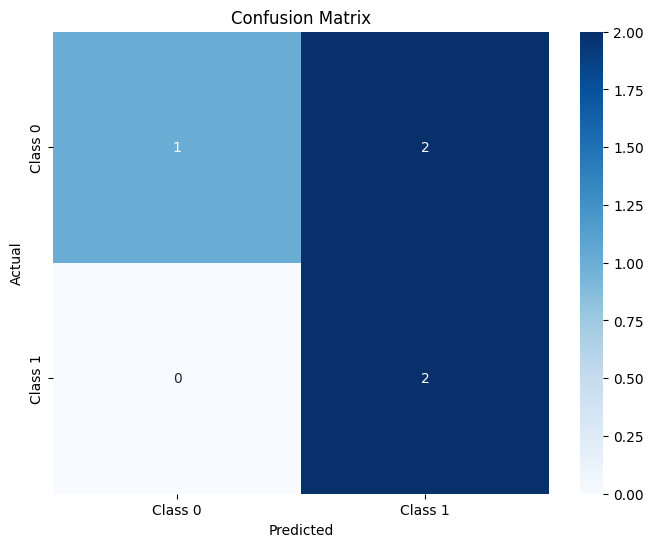

AUROC: 0.6666666666666667


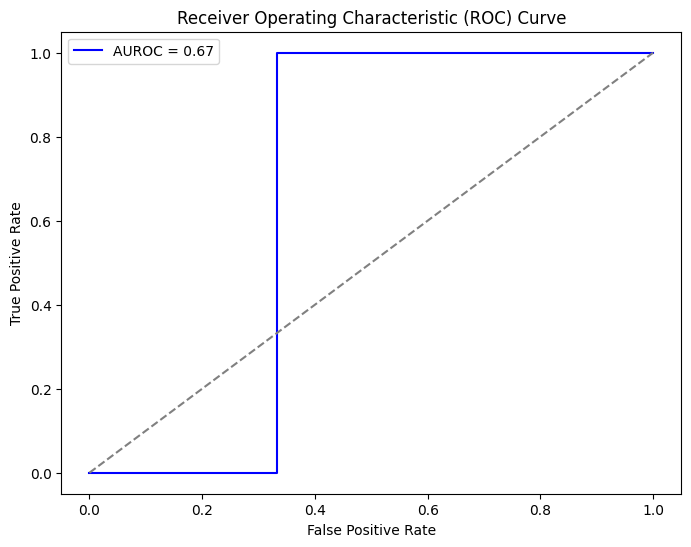

In [ ]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is already loaded and contains the necessary columns

# Define a silent feature extraction function
def extract_features_silent(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract sequences from the dataframe
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Antigen Sequence'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = np.array([extract_features_silent(seq) for seq in antibody_sequences])
antigen_features = np.array([extract_features_silent(seq) for seq in antigen_sequences])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Combine features
combined_features = np.hstack([antibody_features, antigen_features])

# Extract the target variable
# Assuming 'Binding' column is present in the 'merged_df' and has 'Negative' or 'Positive' values
y = merged_df['Binding'].apply(lambda x: 1 if x == 'Positive' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.5, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 100 sequences

In [ ]:
import pandas as pd
import numpy as np

# Assume positive_data and negative_data are your dataframes
positive_sample = positive_data.sample(n=50, random_state=42)
negative_sample = negative_data.sample(n=50, random_state=42)

# Combine the datasets and reset index
balanced_data = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)

# Add a label for tracing back later
balanced_data['Label'] = ['Positive'] * 50 + ['Negative'] * 50

In [ ]:
# Extract antigen and antibody sequences
antigen_sequences = balanced_data['Antigen'].tolist()
antibody_sequences = balanced_data['Antibody'].tolist()

# Function to save sequences in FASTA format
def save_fasta(sequences, filename):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            label = balanced_data.iloc[i]['Label']
            f.write(f">seq{i}_{label}\n")
            f.write(f"{seq}\n")

# Save antigen and antibody sequences
save_fasta(antigen_sequences, 'full_antigen.fasta')
save_fasta(antibody_sequences, 'full_antibody.fasta')

# Ensure the directory exists before moving files
os.makedirs('/content/input_files', exist_ok=True)

# Move files to the input_files directory
shutil.move('full_antigen.fasta', '/content/input_files/full_antigen.fasta')
shutil.move('full_antibody.fasta', '/content/input_files/full_antibody.fasta')

# Verify the content of the FASTA files
print("Full Antigen FASTA:")
!cat /content/input_files/full_antigen.fasta
print("Full Antibody FASTA:")
!cat /content/input_files/full_antibody.fasta

Full Antigen FASTA:
>seq0_Positive
QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAPNLMIFEGTKRPSGVSNRFSGSKSGNTASLTISGLQAEDEADYFCCSYAGFSTWVFGGGTKLSVL
>seq1_Positive
DIQMTQSPSSLSASVGDRVTITCRTSQGIYNYLAWYQQKPGKVPKLLIYGASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQKYKSAPLTFGGGTKVEIK
>seq2_Positive
QSALTQPASVSGSPGQSITISCTGTSSDVGAYNYVSWYQQHPGKAPKLMIYDVSSRPSGVSNRFSGSKSGNTASLTISGLQADDEADYYCSSYTGSSTLVFGGGTKLTVL
>seq3_Positive
DIQMTQSPCTLSASVGDRVTITCRASQNIGSWLAWYQQKPGKAPNLLMYKASTLQSGVPSRFSGSGSGTEFTLTISSLQPDDFATYYCQQYNSYSPVTFGPGTKVDMK
>seq4_Positive
DIVMTQTPDSLAVSLGERATINCKSSQSVLYSSNNKNYLSWYQQKPGQPPKVLIYWASIRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSNPLTFGGGTKVEIK
>seq5_Positive
IQMTQSPSSLSASVGDRVTITCRASQDIRNDLGWFQQKPGTAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCLQDYNYPRTFGQGTKVEIK
>seq6_Positive
DIQLTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTEFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK
>seq7_Positive
EIVLTQSPGTLSLSPGERATLSCRASQSVRSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQY

In [ ]:
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_epidope_for_length(input_fasta, output_base_dir, threshold, length, slice_shift_size):
    output_dir = f"{output_base_dir}/results_length_{length}/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Running EpiDope for slice length {length}...")

    command = f"bash -c 'source activate epidope && epidope -i {input_fasta} -o {output_dir} -t {threshold} -l {length} -s {slice_shift_size}'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running EpiDope for length {length}: {result.stderr}")
        return length, None

    predicted_epitopes_sliced_file = os.path.join(output_dir, "predicted_epitopes_sliced.faa")
    if not os.path.exists(predicted_epitopes_sliced_file):
        print(f"File not found: {predicted_epitopes_sliced_file}")
        return length, None

    with open(predicted_epitopes_sliced_file, 'r') as file:
        lines = file.readlines()
        if not lines:
            print(f"No data in file: {predicted_epitopes_sliced_file}")
            return length, None

    epitope_dict = {}
    current_seq_id = None
    for line in lines:
        line = line.strip()
        if line.startswith('>'):
            current_seq_id = line.split('|')[0][1:]  # Extract sequence ID
            if current_seq_id not in epitope_dict:
                epitope_dict[current_seq_id] = []
        else:
            epitope_dict[current_seq_id].append(line)

    return length, epitope_dict

def run_epidope_and_store_results(input_fasta, output_base_dir, threshold=0.7, max_length=20, slice_shift_size=10):
    # Clear the dictionary before starting the new run
    all_epitopes_dict = {}

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_epidope_for_length, input_fasta, output_base_dir, threshold, length, slice_shift_size)
            for length in range(8, max_length + 1)
        ]
        for future in as_completed(futures):
            length, epitope_dict = future.result()
            if epitope_dict is not None:
                for seq_id, epitopes in epitope_dict.items():
                    if seq_id not in all_epitopes_dict:
                        all_epitopes_dict[seq_id] = []
                    all_epitopes_dict[seq_id].extend(epitopes)
            print(f"Collected epitopes for slice length {length}: {epitope_dict}")

    return all_epitopes_dict

# Example usage with the small sample
input_fasta = '/content/input_files/full_antigen.fasta'
output_base_dir = '/content/output'
epitopes_dict = run_epidope_and_store_results(input_fasta, output_base_dir)
print("Final epitope dictionary:", epitopes_dict)

# Save the dictionary to a file (optional)
import json
with open('/content/epitopes_dict.json', 'w') as f:
    json.dump(epitopes_dict, f)
print("Epitopes dictionary saved to /content/epitopes_dict.json")

Running EpiDope for slice length 8...
Running EpiDope for slice length 9...
Running EpiDope for slice length 10...
Running EpiDope for slice length 12...
Running EpiDope for slice length 11...
Running EpiDope for slice length 14...
Running EpiDope for slice length 13...
Running EpiDope for slice length 16...
Running EpiDope for slice length 17...
Running EpiDope for slice length 15...
Running EpiDope for slice length 18...
Running EpiDope for slice length 19...
Collected epitopes for slice length 9: {'seq0_Positive': ['WFQQHPGKA'], 'seq1_Positive': ['TSQGIYNYL', 'WYQQKPGKV'], 'seq2_Positive': ['YVSWYQQHP'], 'seq3_Positive': ['NIGSWLAWY', 'QKPGKAPNL', 'FGPGTKVDM'], 'seq4_Positive': ['TQTPDSLAV', 'SSQSVLYSS', 'NKNYLSWYQ', 'KPGQPPKVL', 'YWASIRESG'], 'seq5_Positive': ['ASQDIRNDL', 'WFQQKPGTA', 'TYYCLQDYN'], 'seq6_Positive': ['SSYLAWYQQ'], 'seq7_Positive': ['SSYLAWYQQ'], 'seq8_Positive': ['LAWYQQKPG'], 'seq9_Positive': ['FLSSNNKNY', 'AWYQQKPGQ'], 'seq12_Positive': ['YLAWYQQKP'], 'seq13_Posi

In [ ]:
import pandas as pd
import json

# Function to read sequences from a FASTA file
def read_fasta(filepath):
    sequences = {}
    with open(filepath, 'r') as file:
        current_seq_id = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_seq_id = line[1:]  # Remove '>'
                sequences[current_seq_id] = ""
            else:
                sequences[current_seq_id] += line
    return sequences

# Read antibody and antigen sequences from the FASTA files
antibody_sequences = read_fasta('/content/input_files/full_antibody.fasta')
antigen_sequences = read_fasta('/content/input_files/full_antigen.fasta')

# Load the epitopes dictionary (Assuming it is saved as JSON)
with open('/content/epitopes_dict.json', 'r') as file:
    epitopes_dict = json.load(file)

# Convert the antibody sequences, antigen sequences, and epitopes dictionary to DataFrames
antibody_df = pd.DataFrame(list(antibody_sequences.items()), columns=['Sequence ID', 'Antibody Sequence'])
antigen_df = pd.DataFrame(list(antigen_sequences.items()), columns=['Sequence ID', 'Antigen Sequence'])
epitopes_df = pd.DataFrame(list(epitopes_dict.items()), columns=['Sequence ID', 'Epitopes'])

# Merge the antibody and antigen DataFrames on the Sequence ID
sequences_df = pd.merge(antibody_df, antigen_df, on='Sequence ID', how='outer')

# Merge the sequences DataFrame with the epitopes DataFrame
merged_df = pd.merge(sequences_df, epitopes_df, on='Sequence ID', how='left')

# Replace NaN values in the Epitopes column with empty lists
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: x if isinstance(x, list) else [])

# Display the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/content/merged_epitopes_antibody_antigen.csv', index=False)
print("Merged DataFrame saved to /content/merged_epitopes_antibody_antigen.csv")

       Sequence ID                                  Antibody Sequence  \
0    seq0_Positive  QVQLQESGPGLVKPSGTLSLTCAVSGDSISSNTWWSWVRQPPGKGL...   
1    seq1_Positive  EVQLVESGGGFVKPGGSLRLSCAASGFKFSDAWMNWVRQAPGKGLE...   
2    seq2_Positive  EVQLVESGGGLVQPGRSLRLSCAASGFSFEDYAMHWVRQAPGKGLE...   
3    seq3_Positive  QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYYLHWVRQAPGQGLE...   
4    seq4_Positive  QVQLVQSGAEVKKPGSSVKVSCKASGGTFTSYAISWVRQAPGQGLE...   
..             ...                                                ...   
95  seq95_Negative  QLQLQESGPGLVKPSETLSLTCTVSGGSIRSSSYYWGWIRQPPGKG...   
96  seq96_Negative  QVQLVESGGGVVQPGRSLRLSCAASGFIFSTYGMHWVRQAPGKGLE...   
97  seq97_Negative  QVQLVESGGGVVQPGRSLRLSCAASGFTFITCAMYWVRQAPGKGLE...   
98  seq98_Negative  QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...   
99  seq99_Negative  EVHLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...   

                                     Antigen Sequence  \
0   QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAP...   
1   DIQMT

In [ ]:
# Read the merged dataframe
merged_df = pd.read_csv('/content/merged_epitopes_antibody_antigen.csv')

# Extract sequences
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Antigen Sequence'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = [extract_features(seq) for seq in antibody_sequences]
antigen_features = [extract_features(seq) for seq in antigen_sequences]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Convert lists to numpy arrays
antibody_features = np.array(antibody_features)
antigen_features = np.array(antigen_features)

Tokenized Input:
{'input_ids': tensor([[ 0, 16,  7, 16,  4, 16,  9,  8,  6, 14,  6,  4,  7, 15, 14,  8,  6, 11,
          4,  8,  4, 11, 23,  5,  7,  8,  6, 13,  8, 12,  8,  8, 17, 11, 22, 22,
          8, 22,  7, 10, 16, 14, 14,  6, 15,  6,  4,  9, 22, 12,  6,  9, 12, 18,
         21,  8,  6, 17, 11, 17, 19, 17, 14,  8,  4, 15,  8, 10,  4, 11, 20,  8,
         12, 13, 15,  8, 15, 17, 16, 12, 11,  4, 17,  4, 11,  8,  7, 11,  5,  5,
         13, 11,  5,  7, 19, 19, 23,  5, 10,  6, 22, 12,  7,  8,  5,  5, 21, 22,
          6, 16,  6, 11,  4,  7, 11,  7,  8,  8,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Emb

In [ ]:
# Print shapes of the extracted features
print(f"Antibody features shape: {antibody_features.shape}")
print(f"Antigen features shape: {antigen_features.shape}")

Antibody features shape: (100, 320)
Antigen features shape: (100, 320)


In [ ]:
import pandas as pd
import json

# Function to read sequences from a FASTA file
def read_fasta(filepath):
    sequences = {}
    with open(filepath, 'r') as file:
        current_seq_id = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_seq_id = line[1:]  # Remove '>'
                sequences[current_seq_id] = ""
            else:
                sequences[current_seq_id] += line
    return sequences

# Read antibody and antigen sequences from the FASTA files
antibody_sequences = read_fasta('/content/input_files/full_antibody.fasta')
antigen_sequences = read_fasta('/content/input_files/full_antigen.fasta')

# Load the epitopes dictionary (Assuming it is saved as JSON)
with open('/content/epitopes_dict.json', 'r') as file:
    epitopes_dict = json.load(file)

# Convert the antibody sequences, antigen sequences, and epitopes dictionary to DataFrames
antibody_df = pd.DataFrame(list(antibody_sequences.items()), columns=['Sequence ID', 'Antibody Sequence'])
antigen_df = pd.DataFrame(list(antigen_sequences.items()), columns=['Sequence ID', 'Antigen Sequence'])
epitopes_df = pd.DataFrame(list(epitopes_dict.items()), columns=['Sequence ID', 'Epitopes'])

# Create a new column 'Binding' based on the 'Sequence ID'
antibody_df['Binding'] = antibody_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
antigen_df['Binding'] = antigen_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
epitopes_df['Binding'] = epitopes_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')

# Merge the antibody and antigen DataFrames on the Sequence ID
sequences_df = pd.merge(antibody_df, antigen_df, on=['Sequence ID', 'Binding'], how='outer')

# Merge the sequences DataFrame with the epitopes DataFrame
merged_df = pd.merge(sequences_df, epitopes_df, on=['Sequence ID', 'Binding'], how='left')

# Replace NaN values in the Epitopes column with empty lists
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: x if isinstance(x, list) else [])

# Join the epitopes with '|' to form the required string format
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: '|'.join(x))

# Display the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/content/merged_epitopes_antibody_antigen.csv', index=False)
print("Merged DataFrame saved to /content/merged_epitopes_antibody_antigen.csv")

       Sequence ID                                  Antibody Sequence  \
0    seq0_Positive  QVQLQESGPGLVKPSGTLSLTCAVSGDSISSNTWWSWVRQPPGKGL...   
1    seq1_Positive  EVQLVESGGGFVKPGGSLRLSCAASGFKFSDAWMNWVRQAPGKGLE...   
2    seq2_Positive  EVQLVESGGGLVQPGRSLRLSCAASGFSFEDYAMHWVRQAPGKGLE...   
3    seq3_Positive  QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYYLHWVRQAPGQGLE...   
4    seq4_Positive  QVQLVQSGAEVKKPGSSVKVSCKASGGTFTSYAISWVRQAPGQGLE...   
..             ...                                                ...   
95  seq95_Negative  QLQLQESGPGLVKPSETLSLTCTVSGGSIRSSSYYWGWIRQPPGKG...   
96  seq96_Negative  QVQLVESGGGVVQPGRSLRLSCAASGFIFSTYGMHWVRQAPGKGLE...   
97  seq97_Negative  QVQLVESGGGVVQPGRSLRLSCAASGFTFITCAMYWVRQAPGKGLE...   
98  seq98_Negative  QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...   
99  seq99_Negative  EVHLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...   

     Binding                                   Antigen Sequence  \
0   Positive  QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHP

In [ ]:
import pandas as pd

# Check for missing values in each column
missing_values = merged_df.isnull().sum()

# Create a DataFrame to display the results more clearly
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})

# Display the DataFrame
print(missing_values_df)

# Optionally, you can save this DataFrame to a CSV file for further inspection
missing_values_df.to_csv('/content/missing_values.csv', index=False)
print("Missing values DataFrame saved to /content/missing_values.csv")

              Column  Missing Values
0        Sequence ID               0
1  Antibody Sequence               0
2            Binding               0
3   Antigen Sequence               0
4           Epitopes               0
Missing values DataFrame saved to /content/missing_values.csv


Elapsed time for feature extraction: 4.972498178482056 seconds
Accuracy: 0.38
              precision    recall  f1-score   support

           0       0.37      0.75      0.49        20
           1       0.44      0.13      0.21        30

    accuracy                           0.38        50
   macro avg       0.41      0.44      0.35        50
weighted avg       0.41      0.38      0.32        50

Confusion Matrix:
[[15  5]
 [26  4]]


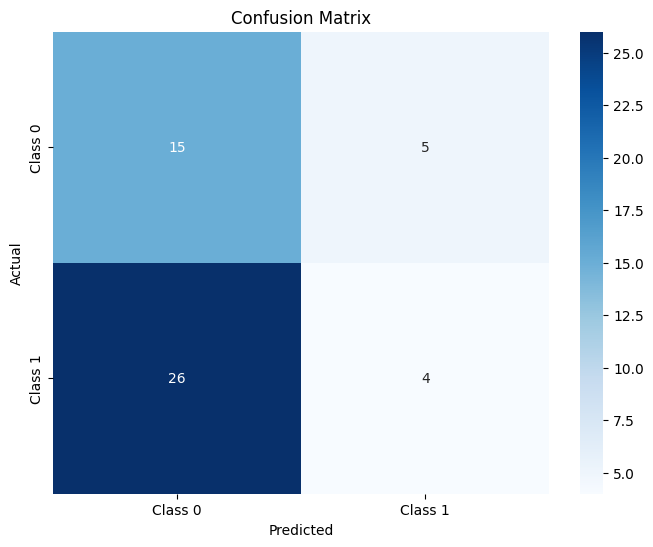

AUROC: 0.5391666666666667


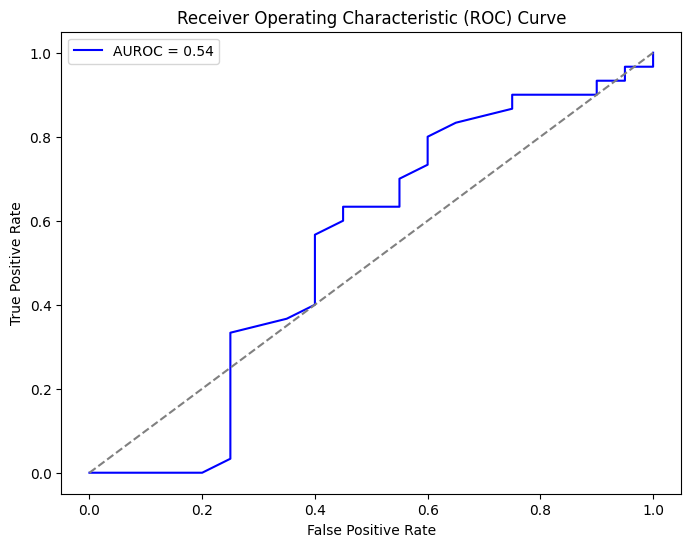

In [ ]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'merged_df' is already loaded and contains the necessary columns

# Define a silent feature extraction function
def extract_features_silent(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract sequences from the dataframe
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Antigen Sequence'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = np.array([extract_features_silent(seq) for seq in antibody_sequences])
antigen_features = np.array([extract_features_silent(seq) for seq in antigen_sequences])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Combine features
combined_features = np.hstack([antibody_features, antigen_features])

# Extract the target variable
# Assuming 'Binding' column is present in the 'merged_df' and has 'Negative' or 'Positive' values
y = merged_df['Binding'].apply(lambda x: 1 if x == 'Positive' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.5, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 300 sequences

In [ ]:
import pandas as pd
import numpy as np

# Assume positive_data and negative_data are your dataframes
positive_sample = positive_data.sample(n=150, random_state=42)
negative_sample = negative_data.sample(n=150, random_state=42)

# Combine the datasets and reset index
balanced_data = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)

# Add a label for tracing back later
balanced_data['Label'] = ['Positive'] * 150 + ['Negative'] * 150

In [ ]:
# Extract antigen and antibody sequences
antigen_sequences = balanced_data['Antigen'].tolist()
antibody_sequences = balanced_data['Antibody'].tolist()

# Function to save sequences in FASTA format
def save_fasta(sequences, filename):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            label = balanced_data.iloc[i]['Label']
            f.write(f">seq{i}_{label}\n")
            f.write(f"{seq}\n")

# Save antigen and antibody sequences
save_fasta(antigen_sequences, 'full_antigen.fasta')
save_fasta(antibody_sequences, 'full_antibody.fasta')

# Ensure the directory exists before moving files
os.makedirs('/content/input_files', exist_ok=True)

# Move files to the input_files directory
shutil.move('full_antigen.fasta', '/content/input_files/full_antigen.fasta')
shutil.move('full_antibody.fasta', '/content/input_files/full_antibody.fasta')

# Verify the content of the FASTA files
print("Full Antigen FASTA:")
!cat /content/input_files/full_antigen.fasta
print("Full Antibody FASTA:")
!cat /content/input_files/full_antibody.fasta

Full Antigen FASTA:
>seq0_Positive
QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAPNLMIFEGTKRPSGVSNRFSGSKSGNTASLTISGLQAEDEADYFCCSYAGFSTWVFGGGTKLSVL
>seq1_Positive
DIQMTQSPSSLSASVGDRVTITCRTSQGIYNYLAWYQQKPGKVPKLLIYGASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQKYKSAPLTFGGGTKVEIK
>seq2_Positive
QSALTQPASVSGSPGQSITISCTGTSSDVGAYNYVSWYQQHPGKAPKLMIYDVSSRPSGVSNRFSGSKSGNTASLTISGLQADDEADYYCSSYTGSSTLVFGGGTKLTVL
>seq3_Positive
DIQMTQSPCTLSASVGDRVTITCRASQNIGSWLAWYQQKPGKAPNLLMYKASTLQSGVPSRFSGSGSGTEFTLTISSLQPDDFATYYCQQYNSYSPVTFGPGTKVDMK
>seq4_Positive
DIVMTQTPDSLAVSLGERATINCKSSQSVLYSSNNKNYLSWYQQKPGQPPKVLIYWASIRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSNPLTFGGGTKVEIK
>seq5_Positive
IQMTQSPSSLSASVGDRVTITCRASQDIRNDLGWFQQKPGTAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCLQDYNYPRTFGQGTKVEIK
>seq6_Positive
DIQLTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTEFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK
>seq7_Positive
EIVLTQSPGTLSLSPGERATLSCRASQSVRSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQY

In [ ]:
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_epidope_for_length(input_fasta, output_base_dir, threshold, length, slice_shift_size):
    output_dir = f"{output_base_dir}/results_length_{length}/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Running EpiDope for slice length {length}...")

    command = f"bash -c 'source activate epidope && epidope -i {input_fasta} -o {output_dir} -t {threshold} -l {length} -s {slice_shift_size}'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running EpiDope for length {length}: {result.stderr}")
        return length, None

    predicted_epitopes_sliced_file = os.path.join(output_dir, "predicted_epitopes_sliced.faa")
    if not os.path.exists(predicted_epitopes_sliced_file):
        print(f"File not found: {predicted_epitopes_sliced_file}")
        return length, None

    with open(predicted_epitopes_sliced_file, 'r') as file:
        lines = file.readlines()
        if not lines:
            print(f"No data in file: {predicted_epitopes_sliced_file}")
            return length, None

    epitope_dict = {}
    current_seq_id = None
    for line in lines:
        line = line.strip()
        if line.startswith('>'):
            current_seq_id = line.split('|')[0][1:]  # Extract sequence ID
            if current_seq_id not in epitope_dict:
                epitope_dict[current_seq_id] = []
        else:
            epitope_dict[current_seq_id].append(line)

    return length, epitope_dict

def run_epidope_and_store_results(input_fasta, output_base_dir, threshold=0.7, max_length=20, slice_shift_size=10):
    # Clear the dictionary before starting the new run
    all_epitopes_dict = {}

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_epidope_for_length, input_fasta, output_base_dir, threshold, length, slice_shift_size)
            for length in range(8, max_length + 1)
        ]
        for future in as_completed(futures):
            length, epitope_dict = future.result()
            if epitope_dict is not None:
                for seq_id, epitopes in epitope_dict.items():
                    if seq_id not in all_epitopes_dict:
                        all_epitopes_dict[seq_id] = []
                    all_epitopes_dict[seq_id].extend(epitopes)
            print(f"Collected epitopes for slice length {length}: {epitope_dict}")

    return all_epitopes_dict

# Example usage with the small sample
input_fasta = '/content/input_files/full_antigen.fasta'
output_base_dir = '/content/output'
epitopes_dict = run_epidope_and_store_results(input_fasta, output_base_dir)
print("Final epitope dictionary:", epitopes_dict)

# Save the dictionary to a file (optional)
import json
with open('/content/epitopes_dict.json', 'w') as f:
    json.dump(epitopes_dict, f)
print("Epitopes dictionary saved to /content/epitopes_dict.json")

Running EpiDope for slice length 8...
Running EpiDope for slice length 10...
Running EpiDope for slice length 9...Running EpiDope for slice length 11...

Running EpiDope for slice length 12...
Running EpiDope for slice length 13...
Running EpiDope for slice length 14...
Running EpiDope for slice length 15...
Running EpiDope for slice length 16...
Running EpiDope for slice length 17...
Running EpiDope for slice length 18...
Running EpiDope for slice length 19...
Running EpiDope for slice length 20...
Collected epitopes for slice length 19: {'seq1_Positive': ['TSQGIYNYLAWYQQKPGKV'], 'seq3_Positive': ['NIGSWLAWYQQKPGKAPNL'], 'seq4_Positive': ['SSQSVLYSSNNKNYLSWYQ', 'NKNYLSWYQQKPGQPPKVL', 'KPGQPPKVLIYWASIRESG'], 'seq5_Positive': ['ASQDIRNDLGWFQQKPGTA'], 'seq9_Positive': ['FLSSNNKNYLAWYQQKPGQ'], 'seq13_Positive': ['GYTVHWYQQLPGTAPKLLI', 'PGTAPKLLIYGDNNRPSGV'], 'seq16_Positive': ['RLEPEDFAVYYCQLYGSSP'], 'seq22_Positive': ['RITCQGDSLRSYYASWYQQ', 'SYYASWYQQKPGQSPVLVI', 'PGQSPVLVIYQDTKRPSGI'], 

In [ ]:
# Read the merged dataframe
merged_df = pd.read_csv('/content/merged_epitopes_antibody_antigen.csv')

# Extract sequences
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Antigen Sequence'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = [extract_features(seq) for seq in antibody_sequences]
antigen_features = [extract_features(seq) for seq in antigen_sequences]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Convert lists to numpy arrays
antibody_features = np.array(antibody_features)
antigen_features = np.array(antigen_features)

Tokenized Input:
{'input_ids': tensor([[ 0, 16,  7, 16,  4, 16,  9,  8,  6, 14,  6,  4,  7, 15, 14,  8,  6, 11,
          4,  8,  4, 11, 23,  5,  7,  8,  6, 13,  8, 12,  8,  8, 17, 11, 22, 22,
          8, 22,  7, 10, 16, 14, 14,  6, 15,  6,  4,  9, 22, 12,  6,  9, 12, 18,
         21,  8,  6, 17, 11, 17, 19, 17, 14,  8,  4, 15,  8, 10,  4, 11, 20,  8,
         12, 13, 15,  8, 15, 17, 16, 12, 11,  4, 17,  4, 11,  8,  7, 11,  5,  5,
         13, 11,  5,  7, 19, 19, 23,  5, 10,  6, 22, 12,  7,  8,  5,  5, 21, 22,
          6, 16,  6, 11,  4,  7, 11,  7,  8,  8,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Emb

In [ ]:
import pandas as pd
import json

# Function to read sequences from a FASTA file
def read_fasta(filepath):
    sequences = {}
    with open(filepath, 'r') as file:
        current_seq_id = None
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                current_seq_id = line[1:]  # Remove '>'
                sequences[current_seq_id] = ""
            else:
                sequences[current_seq_id] += line
    return sequences

# Read antibody and antigen sequences from the FASTA files
antibody_sequences = read_fasta('/content/input_files/full_antibody.fasta')
antigen_sequences = read_fasta('/content/input_files/full_antigen.fasta')

# Load the epitopes dictionary (Assuming it is saved as JSON)
with open('/content/epitopes_dict.json', 'r') as file:
    epitopes_dict = json.load(file)

# Convert the antibody sequences, antigen sequences, and epitopes dictionary to DataFrames
antibody_df = pd.DataFrame(list(antibody_sequences.items()), columns=['Sequence ID', 'Antibody Sequence'])
antigen_df = pd.DataFrame(list(antigen_sequences.items()), columns=['Sequence ID', 'Antigen Sequence'])
epitopes_df = pd.DataFrame(list(epitopes_dict.items()), columns=['Sequence ID', 'Epitopes'])

# Create a new column 'Binding' based on the 'Sequence ID'
antibody_df['Binding'] = antibody_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
antigen_df['Binding'] = antigen_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')
epitopes_df['Binding'] = epitopes_df['Sequence ID'].apply(lambda x: 'Positive' if 'Positive' in x else 'Negative')

# Merge the antibody and antigen DataFrames on the Sequence ID
sequences_df = pd.merge(antibody_df, antigen_df, on=['Sequence ID', 'Binding'], how='outer')

# Merge the sequences DataFrame with the epitopes DataFrame
merged_df = pd.merge(sequences_df, epitopes_df, on=['Sequence ID', 'Binding'], how='left')

# Replace NaN values in the Epitopes column with empty lists
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: x if isinstance(x, list) else [])

# Join the epitopes with '|' to form the required string format
merged_df['Epitopes'] = merged_df['Epitopes'].apply(lambda x: '|'.join(x))

# Display the merged DataFrame
print(merged_df)

# Save the merged DataFrame to a CSV file
merged_df.to_csv('/content/merged_epitopes_antibody_antigen.csv', index=False)
print("Merged DataFrame saved to /content/merged_epitopes_antibody_antigen.csv")

         Sequence ID                                  Antibody Sequence  \
0      seq0_Positive  QVQLQESGPGLVKPSGTLSLTCAVSGDSISSNTWWSWVRQPPGKGL...   
1      seq1_Positive  EVQLVESGGGFVKPGGSLRLSCAASGFKFSDAWMNWVRQAPGKGLE...   
2      seq2_Positive  EVQLVESGGGLVQPGRSLRLSCAASGFSFEDYAMHWVRQAPGKGLE...   
3      seq3_Positive  QVQLVQSGAEVKKPGASVKVSCKASGYTFSNYYLHWVRQAPGQGLE...   
4      seq4_Positive  QVQLVQSGAEVKKPGSSVKVSCKASGGTFTSYAISWVRQAPGQGLE...   
..               ...                                                ...   
295  seq295_Negative  EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...   
296  seq296_Negative  QVQLVESGGGVVQPGRSLRLSCAASGFTLSSYAMHWVRQAPGKGLE...   
297  seq297_Negative  EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMNWVRQAPGKGLE...   
298  seq298_Negative  EVQLVESGGGLVQPGGSLRLSCAASGFTVSSNYMSWVRQAPGKGLE...   
299  seq299_Negative  QLQLQESGPGLVKPSETLSLTCTVSGGSISSSPYYWGWIRQSPGKG...   

      Binding                                   Antigen Sequence  \
0    Positive  QSALTQPASVSGSPGQ

In [ ]:
import pandas as pd

# Check for missing values in each column
missing_values = merged_df.isnull().sum()

# Create a DataFrame to display the results more clearly
missing_values_df = pd.DataFrame({'Column': missing_values.index, 'Missing Values': missing_values.values})

# Display the DataFrame
print(missing_values_df)

# Optionally, you can save this DataFrame to a CSV file for further inspection
missing_values_df.to_csv('/content/missing_values.csv', index=False)
print("Missing values DataFrame saved to /content/missing_values.csv")

              Column  Missing Values
0        Sequence ID               0
1  Antibody Sequence               0
2            Binding               0
3   Antigen Sequence               0
4           Epitopes               0
Missing values DataFrame saved to /content/missing_values.csv


In [2]:
import pandas as pd

# Read the merged dataframe
merged_df = pd.read_csv('/content/merged_epitopes_antibody_antigen (1).csv')

In [7]:
# Define a function to extract features using the ESM2 model
def extract_features(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Ensure no NaN values in the columns to be used
merged_df['Epitopes'] = merged_df['Epitopes'].fillna('')
merged_df['Antibody Sequence'] = merged_df['Antibody Sequence'].fillna('')

# Extract features from the Epitope and Antibody columns
merged_df['Epitope_features'] = merged_df['Epitopes'].apply(extract_features)
merged_df['Antibody_features'] = merged_df['Antibody Sequence'].apply(extract_features)

# Combine the features
combined_features_full = np.hstack((merged_df['Epitope_features'].tolist(), merged_df['Antibody_features'].tolist()))

X_full = np.array(combined_features_full)

Elapsed time for feature extraction: 15.292327880859375 seconds
Accuracy: 0.5266666666666666
              precision    recall  f1-score   support

           0       0.50      0.74      0.60        72
           1       0.58      0.33      0.42        78

    accuracy                           0.53       150
   macro avg       0.54      0.53      0.51       150
weighted avg       0.54      0.53      0.51       150

Confusion Matrix:
[[53 19]
 [52 26]]


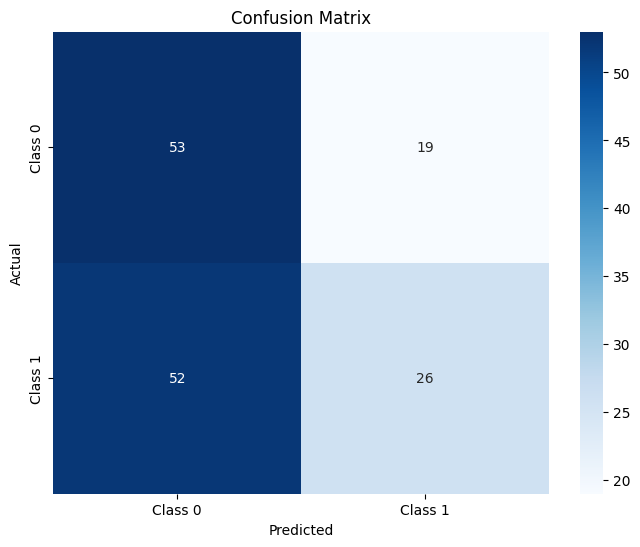

AUROC: 0.5392628205128205


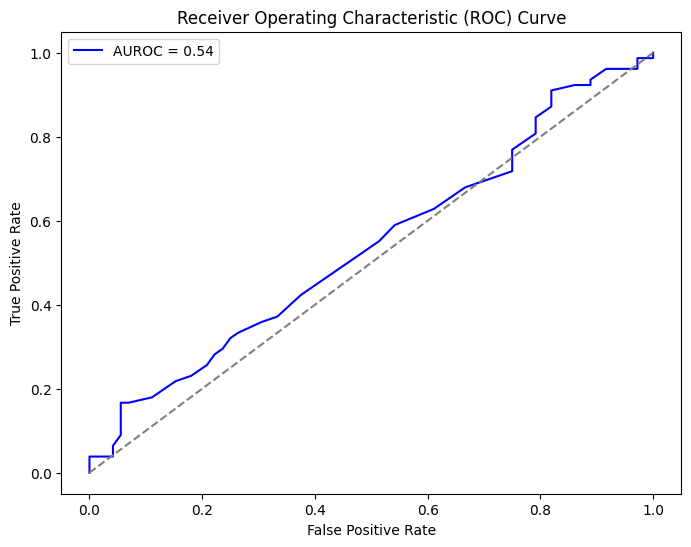

In [10]:
# Define a silent feature extraction function
def extract_features_silent(sequence):
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Extract sequences from the dataframe
antibody_sequences = merged_df['Antibody Sequence'].tolist()
antigen_sequences = merged_df['Epitopes'].tolist()

# Measure time for feature extraction
start_time = time.time()

# Extract features for antibody and antigen sequences
antibody_features = np.array([extract_features_silent(seq) for seq in antibody_sequences])
antigen_features = np.array([extract_features_silent(seq) for seq in antigen_sequences])

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time for feature extraction: {elapsed_time} seconds")

# Combine features
combined_features = np.hstack([antibody_features, antigen_features])

# Extract the target variable
# Assuming 'Binding' column is present in the 'merged_df' and has 'Negative' or 'Positive' values
y = merged_df['Binding'].apply(lambda x: 1 if x == 'Positive' else 0).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.5, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print AUROC
auroc = roc_auc_score(y_test, y_pred_prob)
print(f"AUROC: {auroc}")

# Plot the AUROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### 1000

In [ ]:
import pandas as pd
import numpy as np

# Assume positive_data and negative_data are your dataframes
positive_sample = positive_data.sample(n=500, random_state=42)
negative_sample = negative_data.sample(n=500, random_state=42)

# Combine the datasets and reset index
balanced_data = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)

# Add a label for tracing back later
balanced_data['Label'] = ['Positive'] * 500 + ['Negative'] * 500

In [ ]:
# Extract antigen and antibody sequences
antigen_sequences = balanced_data['Antigen'].tolist()
antibody_sequences = balanced_data['Antibody'].tolist()

# Function to save sequences in FASTA format
def save_fasta(sequences, filename):
    with open(filename, 'w') as f:
        for i, seq in enumerate(sequences):
            label = balanced_data.iloc[i]['Label']
            f.write(f">seq{i}_{label}\n")
            f.write(f"{seq}\n")

# Save antigen and antibody sequences
save_fasta(antigen_sequences, 'full_antigen.fasta')
save_fasta(antibody_sequences, 'full_antibody.fasta')

# Ensure the directory exists before moving files
os.makedirs('/content/input_files', exist_ok=True)

# Move files to the input_files directory
shutil.move('full_antigen.fasta', '/content/input_files/full_antigen.fasta')
shutil.move('full_antibody.fasta', '/content/input_files/full_antibody.fasta')

# Verify the content of the FASTA files
print("Full Antigen FASTA:")
!cat /content/input_files/full_antigen.fasta
print("Full Antibody FASTA:")
!cat /content/input_files/full_antibody.fasta

Full Antigen FASTA:
>seq0_Positive
QSALTQPASVSGSPGQSITISCTGTNSDVGSYNLVSWFQQHPGKAPNLMIFEGTKRPSGVSNRFSGSKSGNTASLTISGLQAEDEADYFCCSYAGFSTWVFGGGTKLSVL
>seq1_Positive
DIQMTQSPSSLSASVGDRVTITCRTSQGIYNYLAWYQQKPGKVPKLLIYGASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDVATYYCQKYKSAPLTFGGGTKVEIK
>seq2_Positive
QSALTQPASVSGSPGQSITISCTGTSSDVGAYNYVSWYQQHPGKAPKLMIYDVSSRPSGVSNRFSGSKSGNTASLTISGLQADDEADYYCSSYTGSSTLVFGGGTKLTVL
>seq3_Positive
DIQMTQSPCTLSASVGDRVTITCRASQNIGSWLAWYQQKPGKAPNLLMYKASTLQSGVPSRFSGSGSGTEFTLTISSLQPDDFATYYCQQYNSYSPVTFGPGTKVDMK
>seq4_Positive
DIVMTQTPDSLAVSLGERATINCKSSQSVLYSSNNKNYLSWYQQKPGQPPKVLIYWASIRESGVPDRFSGSGSGTDFTLTISSLQAEDVAVYYCQQYYSNPLTFGGGTKVEIK
>seq5_Positive
IQMTQSPSSLSASVGDRVTITCRASQDIRNDLGWFQQKPGTAPKLLIYAASTLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCLQDYNYPRTFGQGTKVEIK
>seq6_Positive
DIQLTQSPSFLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLLIYAASTLQSGVPSRFSGSGSGTEFTLTISSLQPEDFATYYCQQLNSYPLTFGGGTKVEIK
>seq7_Positive
EIVLTQSPGTLSLSPGERATLSCRASQSVRSSYLAWYQQKPGQAPRLLIYGASSRATGIPDRFSGSGSGTDFTLTISRLEPEDFAVYYCQQY

In [ ]:
import os
import subprocess
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_epidope_for_length(input_fasta, output_base_dir, threshold, length, slice_shift_size):
    output_dir = f"{output_base_dir}/results_length_{length}/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Running EpiDope for slice length {length}...")

    command = f"bash -c 'source activate epidope && epidope -i {input_fasta} -o {output_dir} -t {threshold} -l {length} -s {slice_shift_size}'"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"Error running EpiDope for length {length}: {result.stderr}")
        return length, None

    predicted_epitopes_sliced_file = os.path.join(output_dir, "predicted_epitopes_sliced.faa")
    if not os.path.exists(predicted_epitopes_sliced_file):
        print(f"File not found: {predicted_epitopes_sliced_file}")
        return length, None

    with open(predicted_epitopes_sliced_file, 'r') as file:
        lines = file.readlines()
        if not lines:
            print(f"No data in file: {predicted_epitopes_sliced_file}")
            return length, None

    epitope_dict = {}
    current_seq_id = None
    for line in lines:
        line = line.strip()
        if line.startswith('>'):
            current_seq_id = line.split('|')[0][1:]  # Extract sequence ID
            if current_seq_id not in epitope_dict:
                epitope_dict[current_seq_id] = []
        else:
            epitope_dict[current_seq_id].append(line)

    return length, epitope_dict

def run_epidope_and_store_results(input_fasta, output_base_dir, threshold=0.7, max_length=20, slice_shift_size=10):
    # Clear the dictionary before starting the new run
    all_epitopes_dict = {}

    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_epidope_for_length, input_fasta, output_base_dir, threshold, length, slice_shift_size)
            for length in range(8, max_length + 1)
        ]
        for future in as_completed(futures):
            length, epitope_dict = future.result()
            if epitope_dict is not None:
                for seq_id, epitopes in epitope_dict.items():
                    if seq_id not in all_epitopes_dict:
                        all_epitopes_dict[seq_id] = []
                    all_epitopes_dict[seq_id].extend(epitopes)
            print(f"Collected epitopes for slice length {length}: {epitope_dict}")

    return all_epitopes_dict

# Example usage with the small sample
input_fasta = '/content/input_files/full_antigen.fasta'
output_base_dir = '/content/output'
epitopes_dict = run_epidope_and_store_results(input_fasta, output_base_dir)
print("Final epitope dictionary:", epitopes_dict)

# Save the dictionary to a file (optional)
import json
with open('/content/epitopes_dict.json', 'w') as f:
    json.dump(epitopes_dict, f)
print("Epitopes dictionary saved to /content/epitopes_dict.json")

Running EpiDope for slice length 8...
Running EpiDope for slice length 9...
Running EpiDope for slice length 10...
Running EpiDope for slice length 13...
Running EpiDope for slice length 12...
Running EpiDope for slice length 11...
Running EpiDope for slice length 14...
Running EpiDope for slice length 15...
Running EpiDope for slice length 16...
Running EpiDope for slice length 17...
Running EpiDope for slice length 18...
Running EpiDope for slice length 19...
